In [1]:
#Imports
import os
from random import uniform
from pathlib import Path
from nufeb_tools import utils,plot
import pandas as pd
from string import Template
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score,mean_squared_error
import seaborn as sns
from tqdm import tqdm
from joblib import Parallel, delayed
import subprocess
from skopt import gp_minimize, forest_minimize, dummy_minimize, gbrt_minimize,load
from skopt.callbacks import CheckpointSaver
from skopt.plots import plot_convergence, plot_objective,plot_gaussian_process
from scipy.optimize import curve_fit
from scipy import interpolate

In [2]:
from tqdm.notebook import tqdm

#class tqdm_skopt(object):
#    def __init__(self, **kwargs):
#        self._bar = tqdm(**kwargs)
#        
#    def __call__(self, res):
#        self._bar.update()
class tqdm_skopt(object):
    def __init__(self, **kwargs):
        self._bar = tqdm(**kwargs)

    def __call__(self, res):
        self._bar.update()

    def __getstate__(self):
        # don't save away the temporary pbar_ object which gets created on
        # epoch begin anew anyway. This avoids pickling errors with tqdm.
        state = self.__dict__.copy()
        del state['_bar']
        return state

In [3]:
test_data = pd.read_excel('/home/jsakkos/nufeb-cyano-e-coli/experimental-data/sucrose-OD-IPTG-sweep recalculated April 2022.xls',sheet_name='data')

def od_func(x):
    """Exponential fit to IPTG vs OD750 experimental data

    Args:
        x (float): IPTG concentration (mM)

    Returns:
        float: Smoothed OD750
    """
    return 0.25482 * np.exp(-x/.06811) + 1.12893
# Smooth OD750 data for fitting
#test_data.loc[:,'OD750'] = od_func(test_data.IPTG)

In [12]:
def recompile(alpha,tau,c,alpha2,tau2,c2):
    """Recompile NUFEB with new fitting parameters

    Args:
        alpha ([type]): [description]
        tau ([type]): [description]
        c ([type]): [description]
        alpha2 ([type]): [description]
        tau2 ([type]): [description]
        c2 ([type]): [description]
    """
    #
    filein = open( r'/home/jsakkos/nufeb-cyano-e-coli/templates/fix_bio_kinetics_monod2.txt' )
    #read it
    src = Template( filein.read() )
    #do the substitution
    result = src.safe_substitute({'alpha' : alpha, 'tau' : tau, 'c' : c,'alpha2' : alpha2, 'tau2' : tau2, 'c2' : c2
    })
    with open('/home/jsakkos/NUFEB/src/USER-NUFEB/fix_bio_kinetics_monod.cpp',"w") as f:
       f.writelines(result)
    #Compile NUFEB
    os.chdir(r'/home/jsakkos/NUFEB')
    #os.system('./install.sh --enable-hdf5 > /dev/null')
    print('Recompiling NUFEB')
    subprocess.run(['./install.sh', '--enable-hdf5'], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    print('Completed recompiling')
def recompile_clean():
    os.system(r'cp /home/jsakkos/nufeb-cyano-e-coli/templates/fix_bio_kinetics_monod_clean.txt /home/jsakkos/NUFEB/src/USER-NUFEB/fix_bio_kinetics_monod.cpp')
    #Compile NUFEB
    os.chdir(r'/home/jsakkos/NUFEB')
    subprocess.run(['./install.sh', '--enable-hdf5'], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

ERROR! Session/line number was not unique in database. History logging moved to new session 58


In [5]:
def collect_data(folder):
    x = utils.get_data(directory=str(folder))
    Volume = np.prod(x.metadata['Dimensions'])
    CellNum2OD = Volume*1e6/0.3e-8
    Biomass2OD = .2825*Volume*1e18
    temp = pd.concat([x.biomass.cyano.reset_index(drop=True)/Biomass2OD,x.biomass.step.reset_index(drop=True)/60/60*x.timestep,x.avg_con.Sucrose.reset_index(drop=True)],axis=1)
    temp.columns=['OD750','Hours','Sucrose']
    temp['IPTG'] = x.metadata['IPTG']
    return temp

    

In [7]:
growth_data = pd.read_excel('/home/jsakkos/nufeb-cyano-e-coli/experimental-data/Biomass CscB-SPS original strain recalculated April 2022.xlsx',sheet_name='Compiled')
growth_data = growth_data.loc[growth_data.IPTG==0]
growth_data = growth_data[['Time','OD750']]
growth_data.columns = ['Hours','OD750']
expdf = growth_data.groupby('Hours').mean().reset_index()
#recompile_clean()
def mu_objective(x):
    mu = x[0]
    os.chdir('/home/jsakkos/NUFEB')
    os.system('nufeb-clean')
    print(f'mu: {mu:.2e}')
    text = f'nufeb-seed --n 3 --od 0.3,0 --d 1e-4,1e-4,1e-4 --grid 20 --t 8700 --mucya {mu} --niter 1000'
    os.system(text)
    #Run new simulations
    os.system('/home/jsakkos/par.sh')
    BASE_DIR = Path(f'runs/')
    folders = [path for path in BASE_DIR.iterdir() if path.is_dir()]

    #Extract output

    tmp=Parallel(n_jobs=-1)(delayed(collect_data)(folder) for folder in folders)
    data = pd.concat(tmp,ignore_index=True)
    df = data.groupby('Hours').mean().reset_index()
    sns.lineplot(x='Hours',y='OD750',data=data,color='r')
    sns.scatterplot(x='Hours',y='OD750',data=expdf)
    plt.show()
    r2_value = r2_score(expdf.OD750,np.interp([0,6,12,24],df['Hours'],df['OD750']))
    muERR = mean_squared_error(expdf.OD750,np.interp([0,6,12,24],df['Hours'],df['OD750']),sample_weight=expdf.OD750,squared=False)
    print(f'R2 = {r2_value:.3f}')
    return muERR

Gaussian Process:   0%|                                                                                                                         | 0/25 [00:00<?, ?it/s]

Iteration No: 1 started. Evaluating function at random point.
mu: 3.59e-05


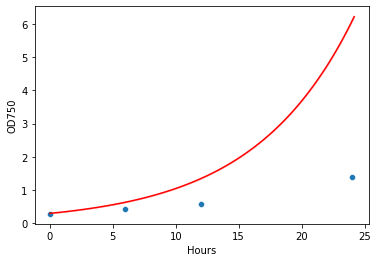

Gaussian Process:   4%|████▌                                                                                                            | 1/25 [00:13<05:15, 13.13s/it]

R2 = -30.338
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 13.1314
Function value obtained: 3.4098
Current minimum: 3.4098
Iteration No: 2 started. Evaluating function at random point.
mu: 1.80e-05


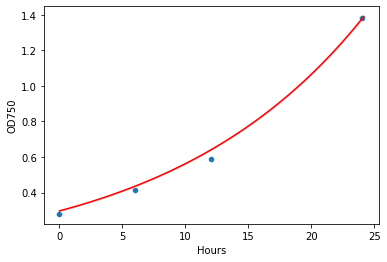

Gaussian Process:   8%|█████████                                                                                                        | 2/25 [00:22<04:08, 10.81s/it]

R2 = 0.995
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 9.1804
Function value obtained: 0.0264
Current minimum: 0.0264
Iteration No: 3 started. Evaluating function at random point.
mu: 3.55e-05


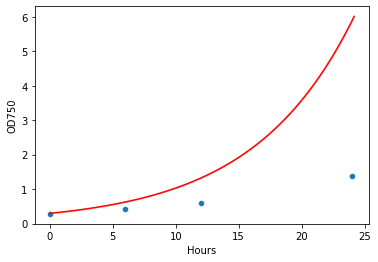

Gaussian Process:  12%|█████████████▌                                                                                                   | 3/25 [00:33<04:01, 10.96s/it]

R2 = -27.768
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 11.1329
Function value obtained: 3.2663
Current minimum: 0.0264
Iteration No: 4 started. Evaluating function at random point.
mu: 1.99e-05


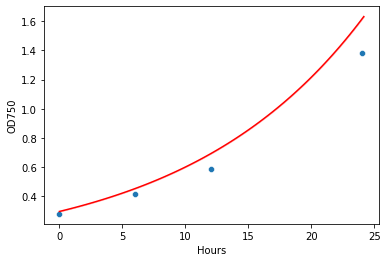

Gaussian Process:  16%|██████████████████                                                                                               | 4/25 [00:42<03:36, 10.32s/it]

R2 = 0.908
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 9.3317
Function value obtained: 0.1750
Current minimum: 0.0264
Iteration No: 5 started. Evaluating function at random point.
mu: 3.25e-05


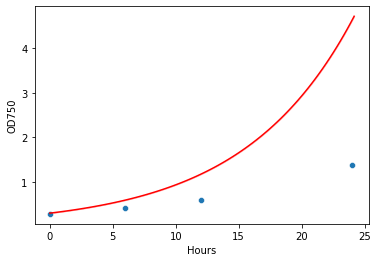

Gaussian Process:  20%|██████████████████████▌                                                                                          | 5/25 [00:53<03:28, 10.42s/it]

R2 = -14.047
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 10.6180
Function value obtained: 2.3579
Current minimum: 0.0264
Iteration No: 6 started. Evaluating function at random point.
mu: 3.45e-05


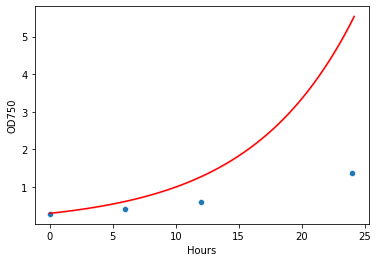

Gaussian Process:  24%|███████████████████████████                                                                                      | 6/25 [01:04<03:20, 10.53s/it]

R2 = -22.218
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 10.7300
Function value obtained: 2.9326
Current minimum: 0.0264
Iteration No: 7 started. Evaluating function at random point.
mu: 4.03e-05


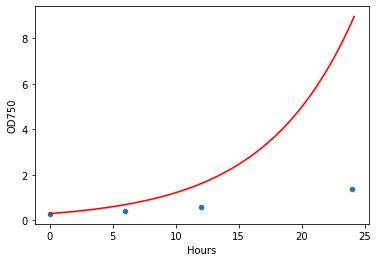

Gaussian Process:  28%|███████████████████████████████▋                                                                                 | 7/25 [01:15<03:15, 10.88s/it]

R2 = -75.346
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 11.6045
Function value obtained: 5.3331
Current minimum: 0.0264
Iteration No: 8 started. Evaluating function at random point.
mu: 4.53e-05


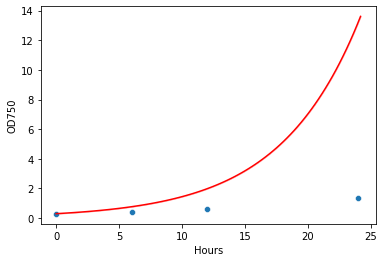

Gaussian Process:  32%|████████████████████████████████████▏                                                                            | 8/25 [01:28<03:17, 11.63s/it]

R2 = -195.823
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 13.2366
Function value obtained: 8.5778
Current minimum: 0.0264
Iteration No: 9 started. Evaluating function at random point.
mu: 2.55e-05


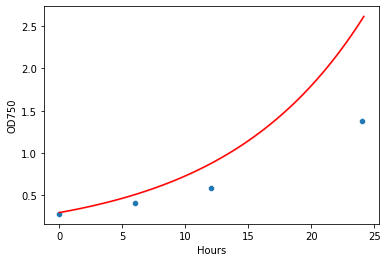

Gaussian Process:  36%|████████████████████████████████████████▋                                                                        | 9/25 [01:38<02:56, 11.02s/it]

R2 = -1.090
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 9.6758
Function value obtained: 0.8719
Current minimum: 0.0264
Iteration No: 10 started. Evaluating function at random point.
mu: 2.39e-05


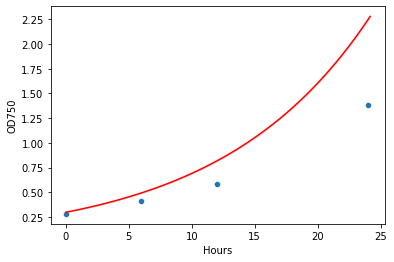

R2 = -0.118


Gaussian Process:  40%|████████████████████████████████████████████▊                                                                   | 10/25 [01:48<02:39, 10.62s/it]

Iteration No: 10 ended. Evaluation done at random point.
Time taken: 9.7402
Function value obtained: 0.6352
Current minimum: 0.0264
Iteration No: 11 started. Searching for the next optimal point.
mu: 1.00e-05


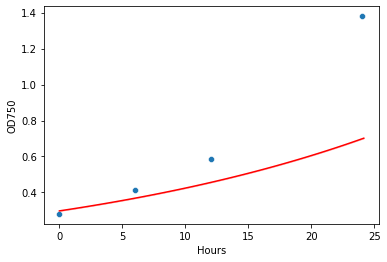

R2 = 0.332


Gaussian Process:  44%|█████████████████████████████████████████████████▎                                                              | 11/25 [01:57<02:20, 10.07s/it]

Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 8.7980
Function value obtained: 0.4956
Current minimum: 0.0264
Iteration No: 12 started. Searching for the next optimal point.
mu: 1.68e-05


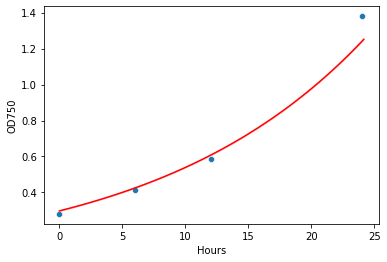

R2 = 0.972


Gaussian Process:  48%|█████████████████████████████████████████████████████▊                                                          | 12/25 [02:06<02:08,  9.85s/it]

Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 9.3650
Function value obtained: 0.1017
Current minimum: 0.0264
Iteration No: 13 started. Searching for the next optimal point.
mu: 1.62e-05


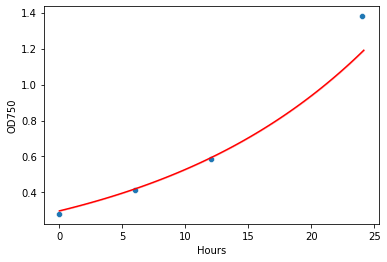

R2 = 0.944


Gaussian Process:  52%|██████████████████████████████████████████████████████████▏                                                     | 13/25 [02:15<01:55,  9.59s/it]

Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 8.9756
Function value obtained: 0.1444
Current minimum: 0.0264
Iteration No: 14 started. Searching for the next optimal point.
mu: 1.80e-05


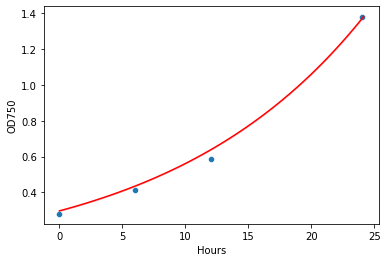

R2 = 0.995


Gaussian Process:  56%|██████████████████████████████████████████████████████████████▋                                                 | 14/25 [02:24<01:43,  9.44s/it]

Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 9.1155
Function value obtained: 0.0268
Current minimum: 0.0264
Iteration No: 15 started. Searching for the next optimal point.
mu: 1.81e-05


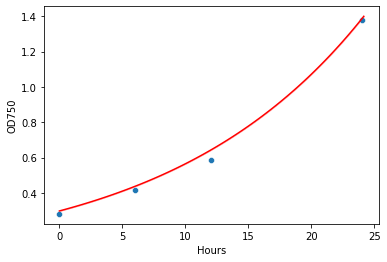

R2 = 0.995


Gaussian Process:  60%|███████████████████████████████████████████████████████████████████▏                                            | 15/25 [02:33<01:33,  9.33s/it]

Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 9.0668
Function value obtained: 0.0274
Current minimum: 0.0264
Iteration No: 16 started. Searching for the next optimal point.
mu: 1.82e-05


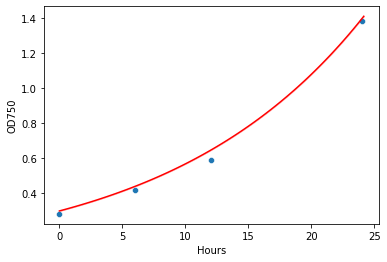

R2 = 0.994


Gaussian Process:  64%|███████████████████████████████████████████████████████████████████████▋                                        | 16/25 [02:42<01:23,  9.28s/it]/home/jsakkos/miniconda3/envs/nufeb/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 9.1658
Function value obtained: 0.0298
Current minimum: 0.0264
Iteration No: 17 started. Searching for the next optimal point.
mu: 1.82e-05


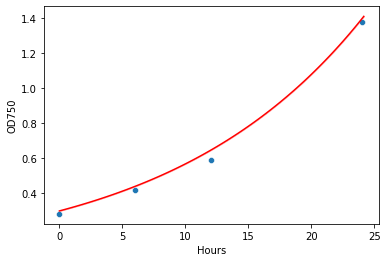

R2 = 0.994


Gaussian Process:  68%|████████████████████████████████████████████████████████████████████████████▏                                   | 17/25 [02:52<01:13,  9.24s/it]

Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 9.1373
Function value obtained: 0.0303
Current minimum: 0.0264
Iteration No: 18 started. Searching for the next optimal point.
mu: 1.28e-05


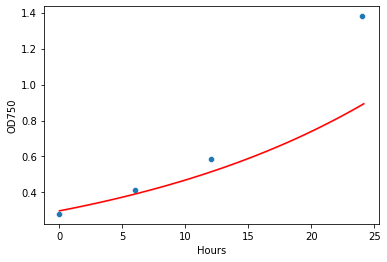

R2 = 0.657


Gaussian Process:  72%|████████████████████████████████████████████████████████████████████████████████▋                               | 18/25 [03:00<01:03,  9.08s/it]

Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 8.7076
Function value obtained: 0.3569
Current minimum: 0.0264
Iteration No: 19 started. Searching for the next optimal point.
mu: 1.81e-05


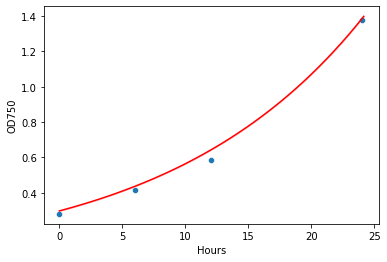

R2 = 0.995


Gaussian Process:  76%|█████████████████████████████████████████████████████████████████████████████████████                           | 19/25 [03:09<00:54,  9.07s/it]

Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 9.0550
Function value obtained: 0.0274
Current minimum: 0.0264
Iteration No: 20 started. Searching for the next optimal point.
mu: 1.83e-05


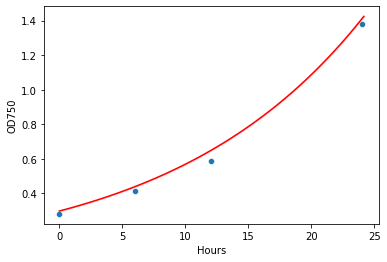

R2 = 0.993


Gaussian Process:  80%|█████████████████████████████████████████████████████████████████████████████████████████▌                      | 20/25 [03:19<00:45,  9.16s/it]

Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 9.3642
Function value obtained: 0.0367
Current minimum: 0.0264
Iteration No: 21 started. Searching for the next optimal point.
mu: 1.79e-05


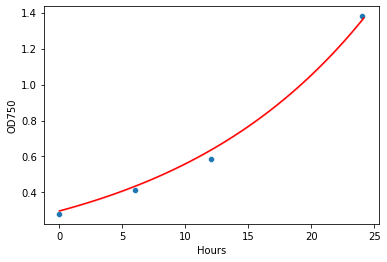

R2 = 0.995


Gaussian Process:  84%|██████████████████████████████████████████████████████████████████████████████████████████████                  | 21/25 [03:28<00:36,  9.14s/it]

Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 9.0940
Function value obtained: 0.0295
Current minimum: 0.0264
Iteration No: 22 started. Searching for the next optimal point.
mu: 1.79e-05


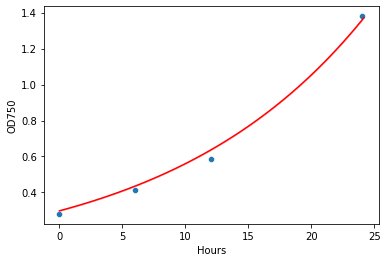

Gaussian Process:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████▌             | 22/25 [03:37<00:27,  9.18s/it]

R2 = 0.995
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 9.2890
Function value obtained: 0.0295
Current minimum: 0.0264
Iteration No: 23 started. Searching for the next optimal point.
mu: 1.83e-05


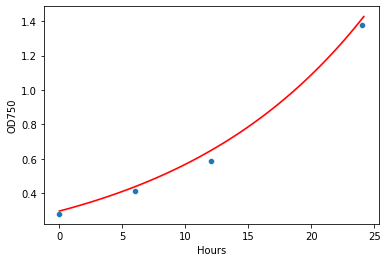

R2 = 0.992


Gaussian Process:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████         | 23/25 [03:47<00:18,  9.33s/it]

Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 9.6599
Function value obtained: 0.0381
Current minimum: 0.0264
Iteration No: 24 started. Searching for the next optimal point.
mu: 1.78e-05


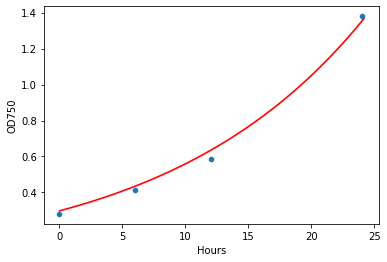

Gaussian Process:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 24/25 [03:56<00:09,  9.25s/it]

R2 = 0.995


/home/jsakkos/miniconda3/envs/nufeb/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 9.0626
Function value obtained: 0.0310
Current minimum: 0.0264
Iteration No: 25 started. Searching for the next optimal point.
mu: 1.80e-05


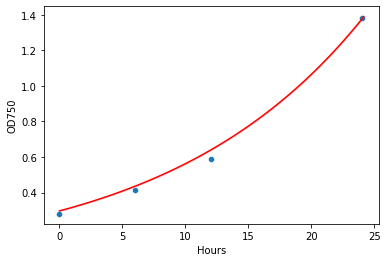

R2 = 0.995


Gaussian Process: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [04:05<00:00,  9.27s/it]

Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 9.3335
Function value obtained: 0.0264
Current minimum: 0.0264


In [84]:
mu_min = float('1e-5')
mu_max = float('5e-5')
mu_bounds = [(mu_min,mu_max)]#,

n_calls = 25
checkpoint_saver_mu = CheckpointSaver(r"/home/jsakkos/nufeb-cyano-e-coli/checkpoints/mu.pkl", compress=9)
mu_res = gp_minimize(mu_objective, mu_bounds,
        n_calls=n_calls,n_initial_points=10,callback=[tqdm_skopt(total=n_calls, desc="Gaussian Process"),checkpoint_saver_mu],verbose=True,random_state=777)


In [8]:
mu_res = load(r"/home/jsakkos/nufeb-cyano-e-coli/checkpoints/mu.pkl")

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

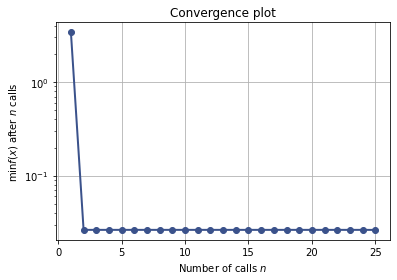

In [85]:
plot_convergence(mu_res,yscale='log')

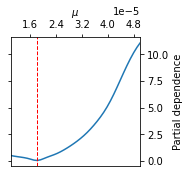

In [86]:
axes = plot_objective(mu_res,dimensions=[r'$\mu$'],cmap='inferno')

In [87]:
mu_res.x

[1.8023870454359037e-05]

mu: 1.80e-05


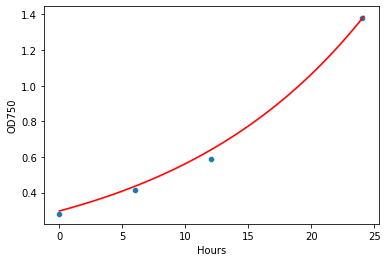

R2 = 0.995


0.02636113142544318

In [88]:
mu_objective(mu_res.x)

In [9]:
def od_func(a,tau,c,iptg):
    return a*np.exp(-iptg/tau)+c
def suc_func(a2,tau2,c2,iptg):
    return -a2*np.exp(-iptg/tau2)+c2

In [16]:
def od_objective(x,mu=mu_res.x[0]):

    a = x[0]
    tau = x[1]
    c = x[2]
    print(f'alpha: {a:.2e},tau: {tau:.2e},c: {c:.2e},mu:{mu:.2e}')
    if all(od_func(a,tau,c,iptg) < 0 for iptg in test_data.IPTG):
        return 100
    elif all(od_func(a,tau,c,iptg) > 2 for iptg in test_data.IPTG):
        return max(od_func(a,tau,c,iptg) for iptg in test_data.IPTG)*100
    recompile(a,tau,c,0,1,0)
    #Clean old simulations
    os.chdir('/home/jsakkos/NUFEB')
    os.system('nufeb-clean')
    #Seed new simulations
    for iptg in test_data.IPTG:
        text = f'nufeb-seed --n 3 --od 0.3,0 --d 1e-4,1e-4,1e-4 --grid 20 --t 8700 --mucya {mu} --iptg {iptg} --niter 1000'
        os.system(text)
    #Run new simulations
    print('Running simulations')
    os.system('/home/jsakkos/par.sh')
    print('Completed simulations')
    BASE_DIR = Path(f'runs/')
    folders = [path for path in BASE_DIR.iterdir() if path.is_dir()]
 
    #Extract output
    print('Extracting results')
    tmp=Parallel(n_jobs=-1)(delayed(collect_data)(folder) for folder in folders)
    print('Plotting output')
    data = pd.concat(tmp,ignore_index=True)
    df = data.loc[(data.Hours == data.Hours.iloc[-1])]
    df = df.sort_values(by='IPTG')
    df = df.reset_index()
    #save in progress plot
    f, ax = plt.subplots()
    ax.set_title('OD750')
    ax.plot(test_data.IPTG,test_data.OD750,marker='o')
    sns.lineplot(x='IPTG',y='OD750',ax=ax,data=df)
    f.tight_layout()
    plt.show()
    temp = df.groupby('IPTG').mean().reset_index()
    #Compare output with experimental data via RMSE
    ODerr  = mean_squared_error(test_data.OD750,temp.OD750,sample_weight=test_data.OD750,squared=False)
    r2_value = r2_score(test_data.OD750,temp.OD750)
    print(f'R2 = {r2_value:.3f}')

    return ODerr


In [17]:
alpha_min = float('1e-2')
alpha_max = float('5e-1')
tau_min = float('1e-2')
tau_max = float('5e-1')
c_min = float('1e-1')
c_max = float('1e0')


Gaussian Process:   0%|          | 0/75 [00:00<?, ?it/s]

Iteration No: 1 started. Evaluating function at random point.
alpha: 3.27e-01,tau: 1.08e-01,c: 6.73e-01,mu:1.80e-05
Recompiling NUFEB
Completed recompiling
Running simulations
Completed simulations
Extracting results
Plotting output


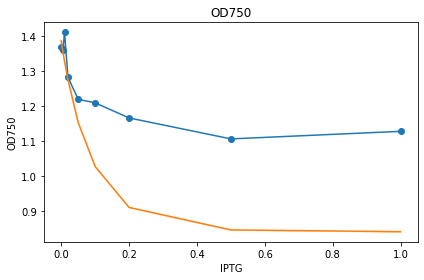

R2 = -1.650
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 67.5825
Function value obtained: 0.1635
Current minimum: 0.1635
Iteration No: 2 started. Evaluating function at random point.
alpha: 1.32e-01,tau: 2.86e-01,c: 6.51e-01,mu:1.80e-05
Recompiling NUFEB
Completed recompiling
Running simulations
Completed simulations
Extracting results
Plotting output


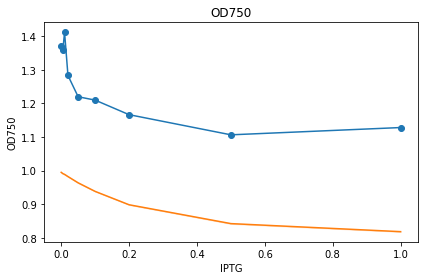

R2 = -8.369
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 64.4047
Function value obtained: 0.3245
Current minimum: 0.1635
Iteration No: 3 started. Evaluating function at random point.
alpha: 3.81e-01,tau: 4.43e-01,c: 4.49e-01,mu:1.80e-05
Recompiling NUFEB
Completed recompiling
Running simulations
Completed simulations
Extracting results
Plotting output


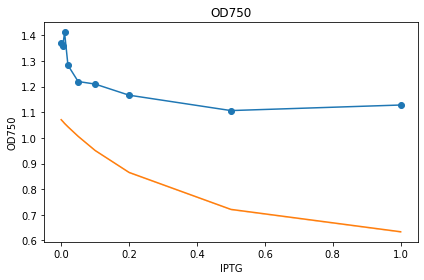

R2 = -8.712
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 64.7606
Function value obtained: 0.3233
Current minimum: 0.1635
Iteration No: 4 started. Evaluating function at random point.
alpha: 1.80e-01,tau: 2.00e-01,c: 5.68e-01,mu:1.80e-05
Recompiling NUFEB
Completed recompiling
Running simulations
Completed simulations
Extracting results
Plotting output


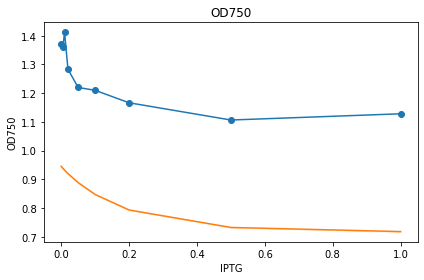

R2 = -13.285
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 64.7078
Function value obtained: 0.3978
Current minimum: 0.1635
Iteration No: 5 started. Evaluating function at random point.
alpha: 1.99e-01,tau: 4.86e-01,c: 9.41e-01,mu:1.80e-05
Recompiling NUFEB
Completed recompiling
Running simulations
Completed simulations
Extracting results
Plotting output


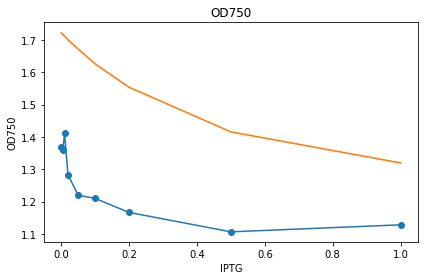

R2 = -10.938
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 66.5514
Function value obtained: 0.3621
Current minimum: 0.1635
Iteration No: 6 started. Evaluating function at random point.
alpha: 2.03e-01,tau: 4.66e-01,c: 8.31e-01,mu:1.80e-05
Recompiling NUFEB
Completed recompiling
Running simulations
Completed simulations
Extracting results
Plotting output


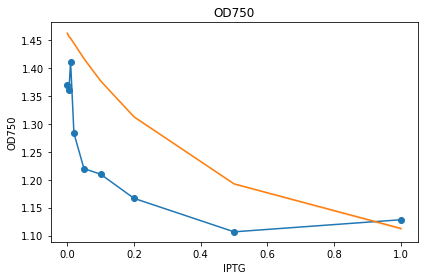

R2 = -0.436
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 65.5226
Function value obtained: 0.1247
Current minimum: 0.1247
Iteration No: 7 started. Evaluating function at random point.
alpha: 6.87e-02,tau: 4.03e-01,c: 9.59e-01,mu:1.80e-05
Recompiling NUFEB
Completed recompiling
Running simulations
Completed simulations
Extracting results
Plotting output


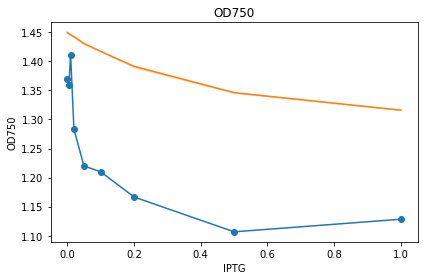

R2 = -1.749
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 65.6873
Function value obtained: 0.1690
Current minimum: 0.1247
Iteration No: 8 started. Evaluating function at random point.
alpha: 1.19e-01,tau: 2.80e-01,c: 2.98e-01,mu:1.80e-05
Recompiling NUFEB
Completed recompiling
Running simulations
Completed simulations
Extracting results
Plotting output


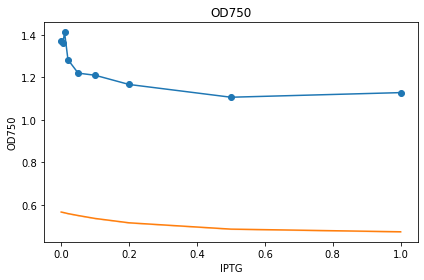

R2 = -46.273
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 63.7835
Function value obtained: 0.7258
Current minimum: 0.1247
Iteration No: 9 started. Evaluating function at random point.
alpha: 1.16e-01,tau: 3.52e-02,c: 1.42e-01,mu:1.80e-05
Recompiling NUFEB
Completed recompiling
Running simulations
Completed simulations
Extracting results
Plotting output


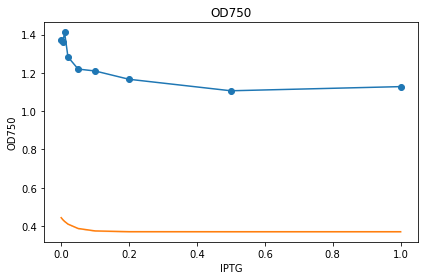

R2 = -65.911
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 64.1713
Function value obtained: 0.8624
Current minimum: 0.1247
Iteration No: 10 started. Evaluating function at random point.
alpha: 3.06e-01,tau: 4.84e-01,c: 1.37e-01,mu:1.80e-05
Recompiling NUFEB
Completed recompiling
Running simulations
Completed simulations
Extracting results
Plotting output


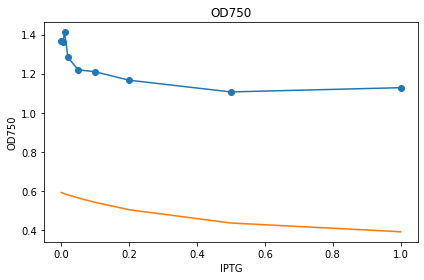

R2 = -46.609
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 64.4549
Function value obtained: 0.7259
Current minimum: 0.1247
Iteration No: 11 started. Searching for the next optimal point.
alpha: 5.00e-01,tau: 1.00e-02,c: 8.09e-01,mu:1.80e-05
Recompiling NUFEB
Completed recompiling
Running simulations
Completed simulations
Extracting results
Plotting output


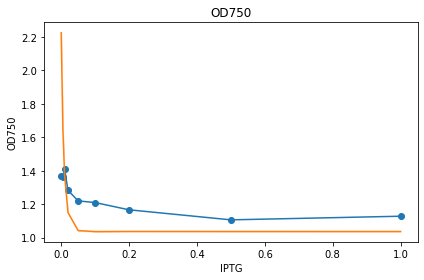

R2 = -8.382
Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 65.3720
Function value obtained: 0.3330
Current minimum: 0.1247
Iteration No: 12 started. Searching for the next optimal point.
alpha: 1.00e-02,tau: 1.00e-02,c: 8.45e-01,mu:1.80e-05
Recompiling NUFEB
Completed recompiling
Running simulations
Completed simulations
Extracting results
Plotting output


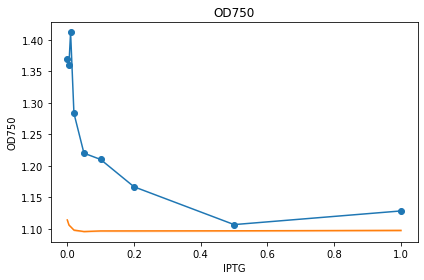

R2 = -1.980
Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 65.1661
Function value obtained: 0.1878
Current minimum: 0.1247
Iteration No: 13 started. Searching for the next optimal point.
alpha: 1.00e-02,tau: 1.00e-02,c: 1.00e+00,mu:1.80e-05
Recompiling NUFEB
Completed recompiling
Running simulations
Completed simulations
Extracting results
Plotting output


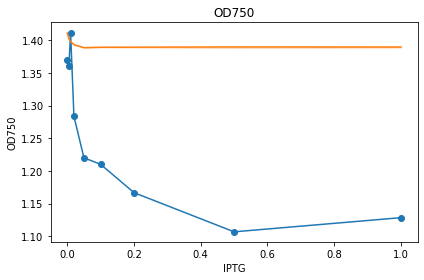

R2 = -1.782
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 65.6250
Function value obtained: 0.1679
Current minimum: 0.1247
Iteration No: 14 started. Searching for the next optimal point.
alpha: 5.00e-01,tau: 5.00e-01,c: 5.99e-01,mu:1.80e-05
Recompiling NUFEB
Completed recompiling
Running simulations
Completed simulations
Extracting results
Plotting output


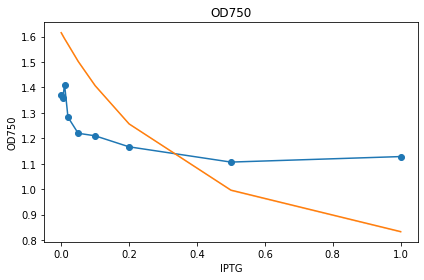

R2 = -3.671
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 66.6344
Function value obtained: 0.2270
Current minimum: 0.1247
Iteration No: 15 started. Searching for the next optimal point.
alpha: 1.00e-02,tau: 5.00e-01,c: 8.72e-01,mu:1.80e-05
Recompiling NUFEB
Completed recompiling
Running simulations
Completed simulations
Extracting results
Plotting output


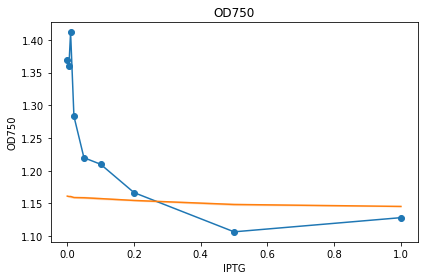

R2 = -0.729
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 65.6310
Function value obtained: 0.1438
Current minimum: 0.1247
Iteration No: 16 started. Searching for the next optimal point.
alpha: 1.00e-02,tau: 5.00e-01,c: 9.03e-01,mu:1.80e-05
Recompiling NUFEB
Completed recompiling
Running simulations
Completed simulations
Extracting results
Plotting output


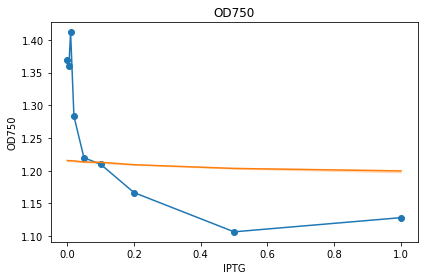

R2 = -0.058
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 65.5148
Function value obtained: 0.1114
Current minimum: 0.1114
Iteration No: 17 started. Searching for the next optimal point.
alpha: 2.15e-01,tau: 5.00e-01,c: 7.86e-01,mu:1.80e-05
Recompiling NUFEB
Completed recompiling
Running simulations


In [ ]:
od_bounds = [(alpha_min,alpha_max),(tau_min,tau_max),(c_min,c_max)]#,

n_calls = 75
checkpoint_saver_od = CheckpointSaver(r"/home/jsakkos/nufeb-cyano-e-coli/checkpoints/od.pkl", compress=9)
od_res = gp_minimize(od_objective, od_bounds,
        n_calls=n_calls,n_initial_points=10,callback=[tqdm_skopt(total=n_calls, desc="Gaussian Process"),checkpoint_saver_od],verbose=True,random_state=777)


In [31]:
od_res = load(r"/home/jsakkos/nufeb-cyano-e-coli/checkpoints/od.pkl")

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

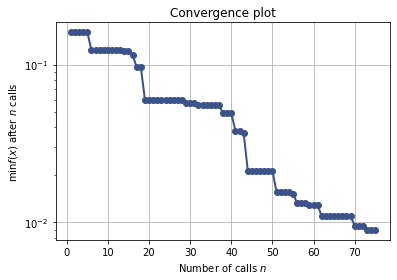

In [101]:
plot_convergence(od_res,yscale='log')

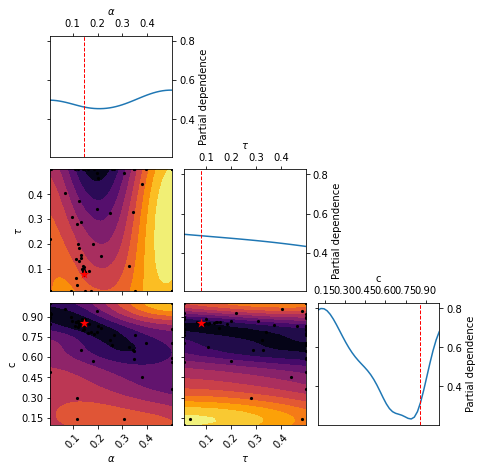

In [102]:
axes = plot_objective(od_res,dimensions=[r'$\alpha$',r'$\tau$','c'],cmap='inferno')

In [103]:
# a, tau, c
od_res.x


[0.1451479831263119, 0.07730685545947749, 0.8544223546219633]

alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,mu:1.80e-05
Recompiling NUFEB
Completed recompiling
Running simulations
Completed simulations
Extracting results
Plotting output


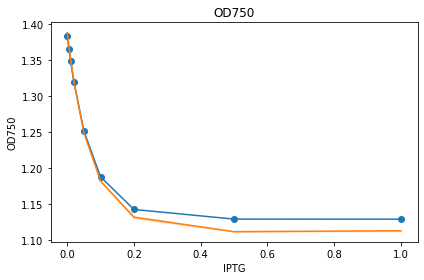

R2 = 0.992


0.008826775191625438

In [104]:
od_objective(od_res.x)

In [105]:
def suc_objective(x,a=od_res.x[0],tau = od_res.x[1],c = od_res.x[2],mu=mu_res.x[0]):
    a2 = x[0]
    tau2 = x[1]
    c2 = x[2]
    print(f'alpha: {a:.2e},tau: {tau:.2e},c: {c:.2e},alpha2: {a2:.2e},tau2: {tau2:.2e},c2: {c2:.2e}')
    #if all(suc_func(a2,tau2,c2,iptg) <=0 for iptg in test_data.IPTG):
    #    return 100
    #elif all(suc_func(a2,tau2,c2,iptg) >1 for iptg in test_data.IPTG):
    #    return 100
    recompile(a,tau,c,a2,tau2,c2)
    #Clean old simulations
    os.chdir('/home/jsakkos/NUFEB')
    os.system('nufeb-clean')
    #Seed new simulations
    for iptg in test_data.IPTG:
        text = f'nufeb-seed --n 3 --od 0.3,0 --d 1e-4,1e-4,1e-4 --grid 20 --t 8700 --mucya {mu} --iptg {iptg} --niter 1000'
        os.system(text)
    #Run new simulations
    os.system('/home/jsakkos/par.sh')
    BASE_DIR = Path(f'runs/')
    folders = [path for path in BASE_DIR.iterdir() if path.is_dir()]

    #Extract output
    n=0
    while True:
        tmp=Parallel(n_jobs=-1)(delayed(collect_data)(folder) for folder in folders)
        data = pd.concat(tmp,ignore_index=True)
        df = data.loc[(data.Hours == data.Hours.iloc[-1])]
        df = df.sort_values(by='IPTG')
        df = df.reset_index()
        temp = df.groupby('IPTG').mean().reset_index()
        if len(test_data.Sucrose)==len(temp.Sucrose):
            break
        elif n >=3:
            print('Tried to import 3 times')
            break
        else:
            n+=1
    #save in progress plot
    f, ax = plt.subplots()
    ax.set_title('Sucrose')
    ax.plot(test_data.IPTG,test_data.Sucrose,marker='o')
    sns.lineplot(x='IPTG',y='Sucrose',ax=ax,data=df)
    f.tight_layout()
    plt.show()

    #Compare output with experimental data via RMSE
    SUCerr = mean_squared_error(test_data.Sucrose,temp.Sucrose,sample_weight=test_data.Sucrose,squared=False)
    r2_value = r2_score(test_data.Sucrose,temp.Sucrose)
    print(f'R2 = {r2_value},alpha: {a2:.2e},tau: {tau2:.2e},c: {c2:.2e}')
    return SUCerr


Gaussian Process:   0%|                                                                                                                         | 0/75 [00:00<?, ?it/s]

Iteration No: 1 started. Evaluating function at random point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 6.82e-01,tau2: 2.09e-02,c2: 6.73e-01
Recompiling NUFEB
Completed recompiling


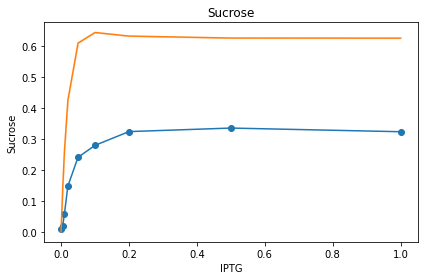


Gaussian Process:   1%|█▍                                                                                                             | 1/75 [01:07<1:23:42, 67.87s/it]

R2 = -3.5753008608233188,alpha: 6.82e-01,tau: 2.09e-02,c: 6.73e-01
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 67.8751
Function value obtained: 0.3149
Current minimum: 0.3149
Iteration No: 2 started. Evaluating function at random point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 3.23e-01,tau2: 5.68e-02,c2: 6.51e-01
Recompiling NUFEB
Completed recompiling


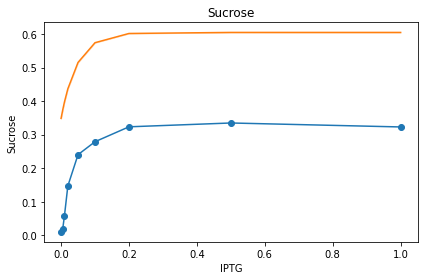


Gaussian Process:   3%|██▉                                                                                                            | 2/75 [02:13<1:20:54, 66.50s/it]

R2 = -4.643347629758564,alpha: 3.23e-01,tau: 5.68e-02,c: 6.51e-01
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 65.5454
Function value obtained: 0.2840
Current minimum: 0.2840
Iteration No: 3 started. Evaluating function at random point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 7.81e-01,tau2: 8.84e-02,c2: 4.49e-01
Recompiling NUFEB
Completed recompiling


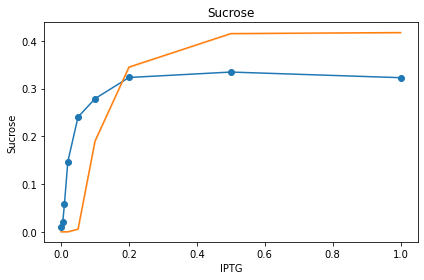


Gaussian Process:   4%|████▍                                                                                                          | 3/75 [03:19<1:19:26, 66.19s/it]

R2 = 0.2889246202979239,alpha: 7.81e-01,tau: 8.84e-02,c: 4.49e-01
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 65.8259
Function value obtained: 0.1177
Current minimum: 0.1177
Iteration No: 4 started. Evaluating function at random point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 4.12e-01,tau2: 3.94e-02,c2: 5.68e-01
Recompiling NUFEB
Completed recompiling


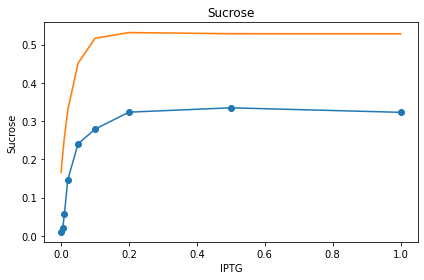


Gaussian Process:   5%|█████▉                                                                                                         | 4/75 [04:24<1:18:02, 65.95s/it]

R2 = -1.4566628800334396,alpha: 4.12e-01,tau: 3.94e-02,c: 5.68e-01
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 65.5617
Function value obtained: 0.2079
Current minimum: 0.1177
Iteration No: 5 started. Evaluating function at random point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 4.48e-01,tau2: 9.71e-02,c2: 9.41e-01
Recompiling NUFEB
Completed recompiling


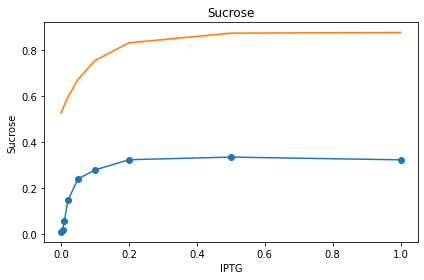


Gaussian Process:   7%|███████▍                                                                                                       | 5/75 [05:30<1:16:49, 65.85s/it]

R2 = -14.356649682078464,alpha: 4.48e-01,tau: 9.71e-02,c: 9.41e-01
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 65.6721
Function value obtained: 0.5028
Current minimum: 0.1177
Iteration No: 6 started. Evaluating function at random point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 4.54e-01,tau2: 9.30e-02,c2: 8.31e-01
Recompiling NUFEB
Completed recompiling


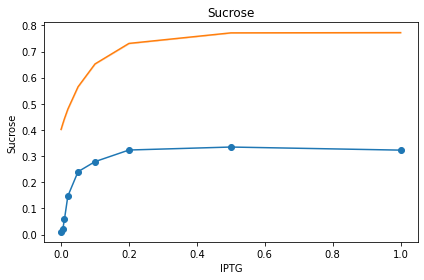


Gaussian Process:   8%|████████▉                                                                                                      | 6/75 [06:36<1:15:46, 65.89s/it]

R2 = -8.367885843039497,alpha: 4.54e-01,tau: 9.30e-02,c: 8.31e-01
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 65.9835
Function value obtained: 0.3992
Current minimum: 0.1177
Iteration No: 7 started. Evaluating function at random point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 2.08e-01,tau2: 8.04e-02,c2: 9.59e-01
Recompiling NUFEB
Completed recompiling


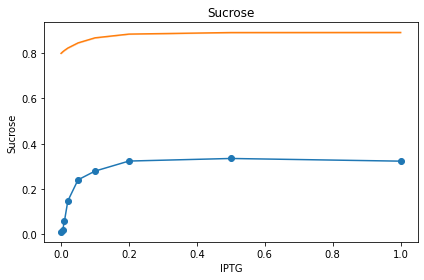


Gaussian Process:   9%|██████████▎                                                                                                    | 7/75 [07:41<1:14:28, 65.72s/it]

R2 = -25.69405671301259,alpha: 2.08e-01,tau: 8.04e-02,c: 9.59e-01
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 65.3481
Function value obtained: 0.5946
Current minimum: 0.1177
Iteration No: 8 started. Evaluating function at random point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 3.00e-01,tau2: 5.55e-02,c2: 2.98e-01
Recompiling NUFEB
Completed recompiling


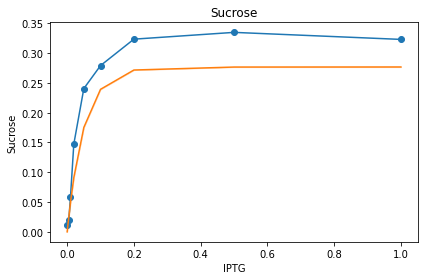


Gaussian Process:  11%|███████████▊                                                                                                   | 8/75 [08:47<1:13:29, 65.81s/it]

R2 = 0.8813607154487157,alpha: 3.00e-01,tau: 5.55e-02,c: 2.98e-01
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 66.0161
Function value obtained: 0.0517
Current minimum: 0.0517
Iteration No: 9 started. Evaluating function at random point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 2.95e-01,tau2: 6.09e-03,c2: 1.42e-01
Recompiling NUFEB
Completed recompiling


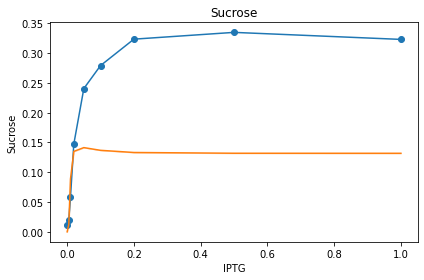


Gaussian Process:  12%|█████████████▎                                                                                                 | 9/75 [09:53<1:12:25, 65.84s/it]

R2 = 0.012467044248669845,alpha: 2.95e-01,tau: 6.09e-03,c: 1.42e-01
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 65.9107
Function value obtained: 0.1616
Current minimum: 0.0517
Iteration No: 10 started. Evaluating function at random point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 6.44e-01,tau2: 9.68e-02,c2: 1.37e-01
Recompiling NUFEB
Completed recompiling


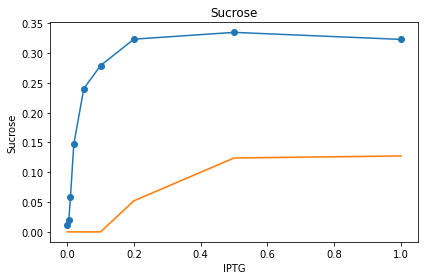


Gaussian Process:  13%|██████████████▋                                                                                               | 10/75 [11:01<1:11:53, 66.35s/it]

R2 = -1.1600516636952403,alpha: 6.44e-01,tau: 9.68e-02,c: 1.37e-01
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 67.4999
Function value obtained: 0.2277
Current minimum: 0.0517
Iteration No: 11 started. Evaluating function at random point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 8.95e-01,tau2: 4.16e-03,c2: 8.38e-01
Recompiling NUFEB
Completed recompiling


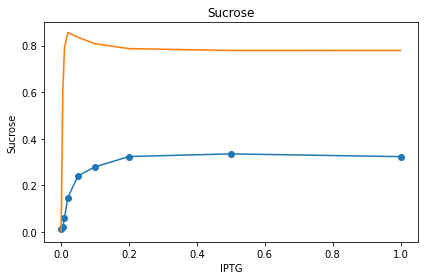


Gaussian Process:  15%|████████████████▏                                                                                             | 11/75 [12:08<1:10:56, 66.50s/it]

R2 = -16.911283847301025,alpha: 8.95e-01,tau: 4.16e-03,c: 8.38e-01
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 66.8408
Function value obtained: 0.5249
Current minimum: 0.0517
Iteration No: 12 started. Evaluating function at random point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 8.32e-01,tau2: 9.35e-03,c2: 6.60e-01
Recompiling NUFEB
Completed recompiling


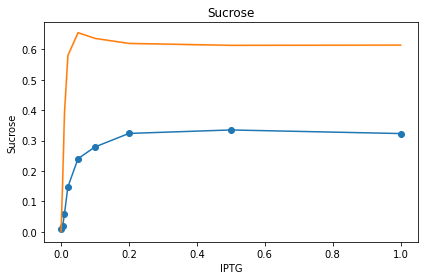


Gaussian Process:  16%|█████████████████▌                                                                                            | 12/75 [13:13<1:09:37, 66.31s/it]

R2 = -4.939063750737285,alpha: 8.32e-01,tau: 9.35e-03,c: 6.60e-01
Iteration No: 12 ended. Evaluation done at random point.
Time taken: 65.8602
Function value obtained: 0.3333
Current minimum: 0.0517
Iteration No: 13 started. Evaluating function at random point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 8.35e-01,tau2: 9.03e-02,c2: 5.65e-01
Recompiling NUFEB
Completed recompiling


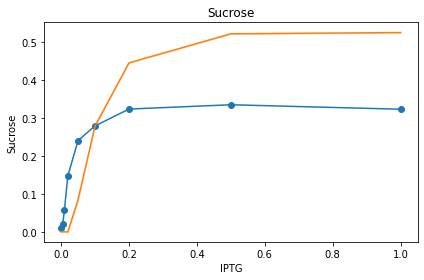


Gaussian Process:  17%|███████████████████                                                                                           | 13/75 [14:19<1:08:19, 66.12s/it]

R2 = 0.04439653251368458,alpha: 8.35e-01,tau: 9.03e-02,c: 5.65e-01
Iteration No: 13 ended. Evaluation done at random point.
Time taken: 65.6817
Function value obtained: 0.1497
Current minimum: 0.0517
Iteration No: 14 started. Evaluating function at random point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 5.83e-01,tau2: 7.80e-02,c2: 3.63e-01
Recompiling NUFEB
Completed recompiling


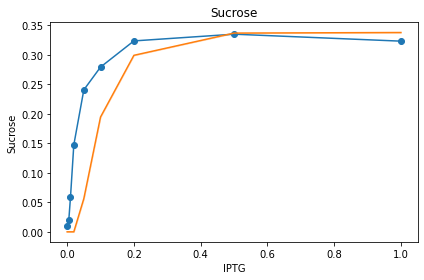


Gaussian Process:  19%|████████████████████▌                                                                                         | 14/75 [15:25<1:07:08, 66.03s/it]

R2 = 0.5405912060032096,alpha: 5.83e-01,tau: 7.80e-02,c: 3.63e-01
Iteration No: 14 ended. Evaluation done at random point.
Time taken: 65.8411
Function value obtained: 0.0892
Current minimum: 0.0517
Iteration No: 15 started. Evaluating function at random point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 9.69e-01,tau2: 5.13e-02,c2: 1.63e-01
Recompiling NUFEB
Completed recompiling


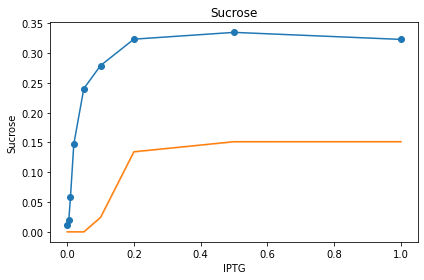


Gaussian Process:  20%|██████████████████████                                                                                        | 15/75 [16:33<1:06:38, 66.64s/it]

R2 = -0.6815452094693819,alpha: 9.69e-01,tau: 5.13e-02,c: 1.63e-01
Iteration No: 15 ended. Evaluation done at random point.
Time taken: 68.0392
Function value obtained: 0.1975
Current minimum: 0.0517
Iteration No: 16 started. Evaluating function at random point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 6.38e-01,tau2: 9.42e-02,c2: 8.90e-01
Recompiling NUFEB
Completed recompiling


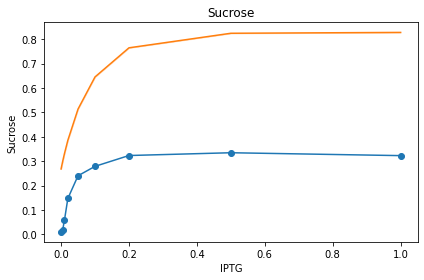


Gaussian Process:  21%|███████████████████████▍                                                                                      | 16/75 [17:39<1:05:18, 66.41s/it]

R2 = -6.992877119191557,alpha: 6.38e-01,tau: 9.42e-02,c: 8.90e-01
Iteration No: 16 ended. Evaluation done at random point.
Time taken: 65.8703
Function value obtained: 0.4129
Current minimum: 0.0517
Iteration No: 17 started. Evaluating function at random point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 6.13e-01,tau2: 2.60e-02,c2: 9.69e-01
Recompiling NUFEB
Completed recompiling


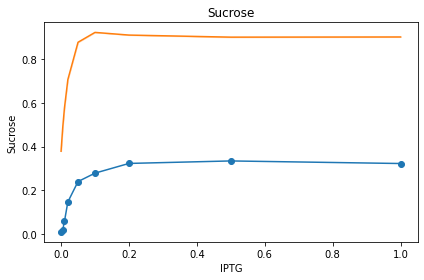


Gaussian Process:  23%|████████████████████████▉                                                                                     | 17/75 [18:45<1:03:58, 66.17s/it]

R2 = -17.750306708696733,alpha: 6.13e-01,tau: 2.60e-02,c: 9.69e-01
Iteration No: 17 ended. Evaluation done at random point.
Time taken: 65.6251
Function value obtained: 0.5914
Current minimum: 0.0517
Iteration No: 18 started. Evaluating function at random point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 3.72e-01,tau2: 4.77e-03,c2: 7.08e-01
Recompiling NUFEB
Completed recompiling


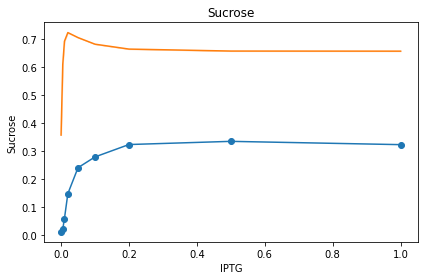


Gaussian Process:  24%|██████████████████████████▍                                                                                   | 18/75 [19:50<1:02:44, 66.05s/it]

R2 = -12.048908346888311,alpha: 3.72e-01,tau: 4.77e-03,c: 7.08e-01
Iteration No: 18 ended. Evaluation done at random point.
Time taken: 65.7719
Function value obtained: 0.4070
Current minimum: 0.0517
Iteration No: 19 started. Evaluating function at random point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 3.76e-01,tau2: 9.90e-02,c2: 5.35e-01
Recompiling NUFEB
Completed recompiling


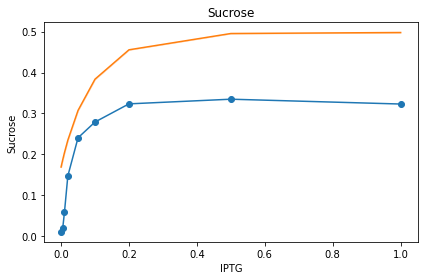


Gaussian Process:  25%|███████████████████████████▊                                                                                  | 19/75 [20:56<1:01:39, 66.06s/it]

R2 = -0.16360535065049953,alpha: 3.76e-01,tau: 9.90e-02,c: 5.35e-01
Iteration No: 19 ended. Evaluation done at random point.
Time taken: 66.0797
Function value obtained: 0.1346
Current minimum: 0.0517
Iteration No: 20 started. Evaluating function at random point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 9.38e-01,tau2: 5.00e-02,c2: 4.06e-01
Recompiling NUFEB
Completed recompiling


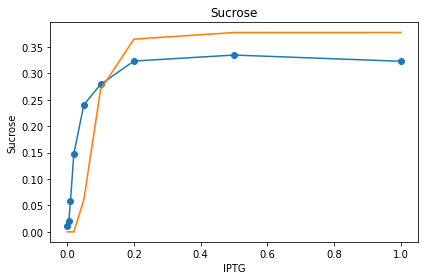

R2 = 0.5614958004459258,alpha: 9.38e-01,tau: 5.00e-02,c: 4.06e-01



Gaussian Process:  27%|█████████████████████████████▎                                                                                | 20/75 [22:02<1:00:30, 66.00s/it]

Iteration No: 20 ended. Evaluation done at random point.
Time taken: 65.8762
Function value obtained: 0.0876
Current minimum: 0.0517
Iteration No: 21 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 1.00e-01,tau2: 1.00e-03,c2: 3.37e-01
Recompiling NUFEB
Completed recompiling


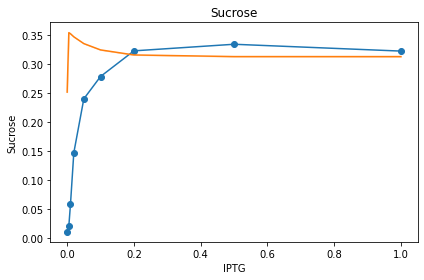

R2 = -1.1027140095902181,alpha: 1.00e-01,tau: 1.00e-03,c: 3.37e-01



Gaussian Process:  28%|███████████████████████████████▎                                                                                | 21/75 [23:08<59:18, 65.90s/it]

Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 65.6732
Function value obtained: 0.0984
Current minimum: 0.0517
Iteration No: 22 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 1.00e-01,tau2: 5.53e-02,c2: 3.20e-01
Recompiling NUFEB
Completed recompiling


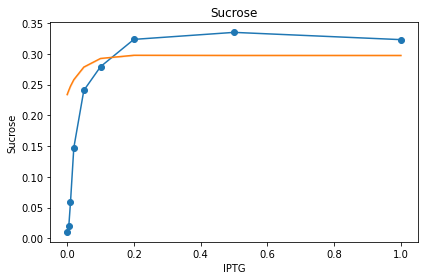

R2 = -0.02551228479195755,alpha: 1.00e-01,tau: 5.53e-02,c: 3.20e-01



Gaussian Process:  29%|████████████████████████████████▊                                                                               | 22/75 [24:13<58:07, 65.81s/it]

Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 65.5804
Function value obtained: 0.0621
Current minimum: 0.0517
Iteration No: 23 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 4.93e-01,tau2: 3.07e-02,c2: 3.31e-01
Recompiling NUFEB
Completed recompiling


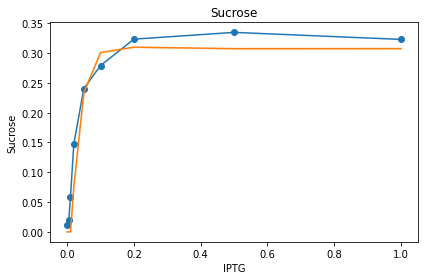

R2 = 0.9275448255207336,alpha: 4.93e-01,tau: 3.07e-02,c: 3.31e-01



Gaussian Process:  31%|██████████████████████████████████▎                                                                             | 23/75 [25:19<57:04, 65.85s/it]

Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 65.9624
Function value obtained: 0.0292
Current minimum: 0.0292
Iteration No: 24 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 6.71e-01,tau2: 1.26e-02,c2: 3.22e-01
Recompiling NUFEB
Completed recompiling


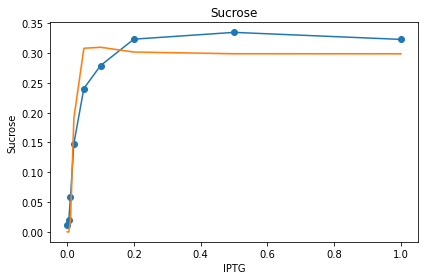

R2 = 0.9199563380013073,alpha: 6.71e-01,tau: 1.26e-02,c: 3.22e-01



Gaussian Process:  32%|███████████████████████████████████▊                                                                            | 24/75 [26:26<56:15, 66.18s/it]

Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 66.9611
Function value obtained: 0.0380
Current minimum: 0.0292
Iteration No: 25 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 1.00e-01,tau2: 1.00e-01,c2: 3.11e-01
Recompiling NUFEB
Completed recompiling


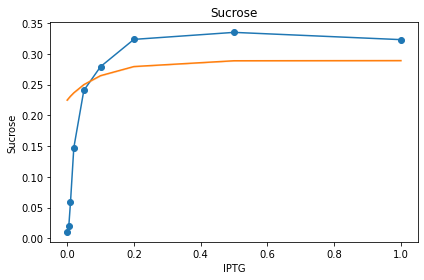

R2 = 0.09984169876294946,alpha: 1.00e-01,tau: 1.00e-01,c: 3.11e-01



Gaussian Process:  33%|█████████████████████████████████████▎                                                                          | 25/75 [27:32<55:04, 66.08s/it]

Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 65.8340
Function value obtained: 0.0591
Current minimum: 0.0292
Iteration No: 26 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 4.84e-01,tau2: 2.28e-02,c2: 2.91e-01
Recompiling NUFEB
Completed recompiling


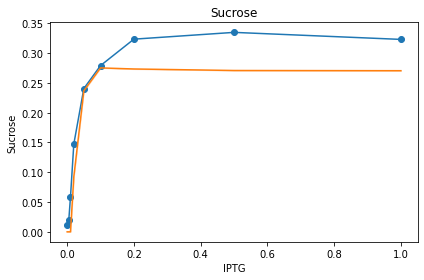

R2 = 0.8891873030588158,alpha: 4.84e-01,tau: 2.28e-02,c: 2.91e-01



Gaussian Process:  35%|██████████████████████████████████████▊                                                                         | 26/75 [28:38<53:51, 65.96s/it]

Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 65.6767
Function value obtained: 0.0463
Current minimum: 0.0292
Iteration No: 27 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 1.00e+00,tau2: 1.00e-03,c2: 3.25e-01
Recompiling NUFEB
Completed recompiling


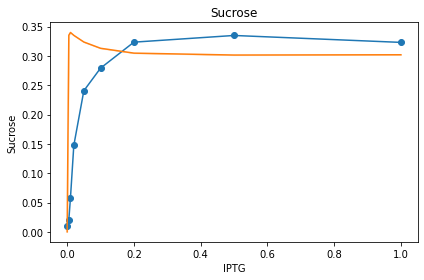

R2 = -0.523047082079708,alpha: 1.00e+00,tau: 1.00e-03,c: 3.25e-01



Gaussian Process:  36%|████████████████████████████████████████▎                                                                       | 27/75 [29:43<52:38, 65.81s/it]

Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 65.4578
Function value obtained: 0.0911
Current minimum: 0.0292
Iteration No: 28 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 5.51e-01,tau2: 2.26e-02,c2: 3.57e-01
Recompiling NUFEB
Completed recompiling


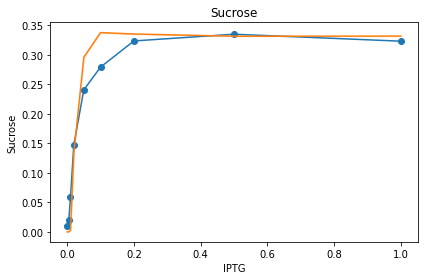

R2 = 0.9283854725428828,alpha: 5.51e-01,tau: 2.26e-02,c: 3.57e-01



Gaussian Process:  37%|█████████████████████████████████████████▊                                                                      | 28/75 [30:49<51:36, 65.88s/it]

Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 66.0454
Function value obtained: 0.0338
Current minimum: 0.0292
Iteration No: 29 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 1.00e-01,tau2: 1.00e-01,c2: 1.00e-01
Recompiling NUFEB
Completed recompiling


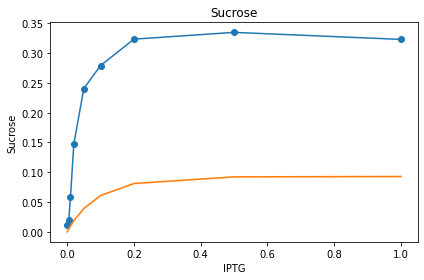

R2 = -0.8887192165943907,alpha: 1.00e-01,tau: 1.00e-01,c: 1.00e-01



Gaussian Process:  39%|███████████████████████████████████████████▎                                                                    | 29/75 [31:56<50:47, 66.24s/it]

Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 67.0859
Function value obtained: 0.2164
Current minimum: 0.0292
Iteration No: 30 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 5.27e-01,tau2: 1.53e-03,c2: 3.37e-01
Recompiling NUFEB
Completed recompiling


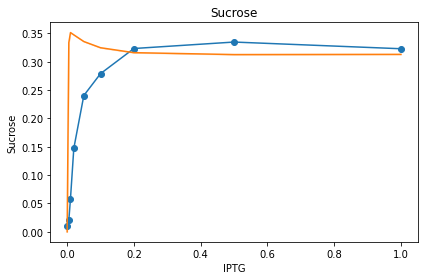

R2 = -0.6075930386342658,alpha: 5.27e-01,tau: 1.53e-03,c: 3.37e-01



Gaussian Process:  40%|████████████████████████████████████████████▊                                                                   | 30/75 [33:02<49:33, 66.07s/it]

Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 65.6807
Function value obtained: 0.0956
Current minimum: 0.0292
Iteration No: 31 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 1.00e-01,tau2: 3.21e-02,c2: 3.21e-01
Recompiling NUFEB
Completed recompiling


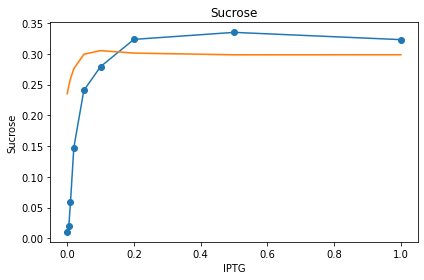

R2 = -0.13025400531098397,alpha: 1.00e-01,tau: 3.21e-02,c: 3.21e-01



Gaussian Process:  41%|██████████████████████████████████████████████▎                                                                 | 31/75 [34:08<48:23, 65.99s/it]

Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 65.7922
Function value obtained: 0.0687
Current minimum: 0.0292
Iteration No: 32 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 5.98e-01,tau2: 3.41e-02,c2: 3.33e-01
Recompiling NUFEB
Completed recompiling


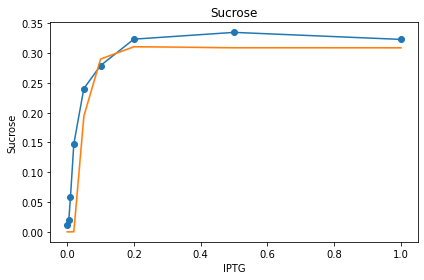

R2 = 0.8040934553440668,alpha: 5.98e-01,tau: 3.41e-02,c: 3.33e-01



Gaussian Process:  43%|███████████████████████████████████████████████▊                                                                | 32/75 [35:14<47:20, 66.06s/it]

Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 66.2158
Function value obtained: 0.0496
Current minimum: 0.0292
Iteration No: 33 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 1.00e-01,tau2: 1.00e-01,c2: 3.88e-01
Recompiling NUFEB
Completed recompiling


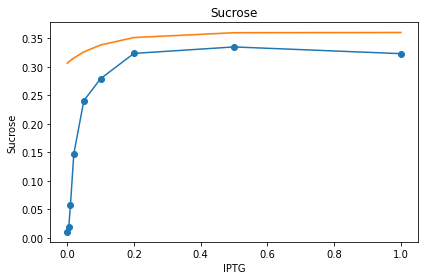

R2 = -0.8816139917607875,alpha: 1.00e-01,tau: 1.00e-01,c: 3.88e-01



Gaussian Process:  44%|█████████████████████████████████████████████████▎                                                              | 33/75 [36:20<46:14, 66.07s/it]

Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 66.1070
Function value obtained: 0.0903
Current minimum: 0.0292
Iteration No: 34 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 4.47e-01,tau2: 4.02e-02,c2: 3.59e-01
Recompiling NUFEB
Completed recompiling


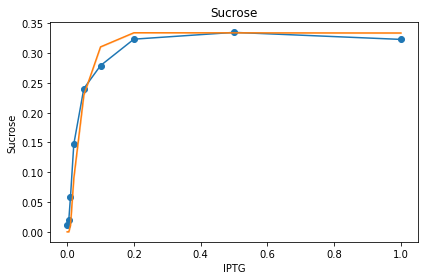

R2 = 0.9499202574882918,alpha: 4.47e-01,tau: 4.02e-02,c: 3.59e-01



Gaussian Process:  45%|██████████████████████████████████████████████████▊                                                             | 34/75 [37:27<45:10, 66.11s/it]

Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 66.2121
Function value obtained: 0.0240
Current minimum: 0.0240
Iteration No: 35 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 4.11e-01,tau2: 4.22e-02,c2: 3.71e-01
Recompiling NUFEB
Completed recompiling


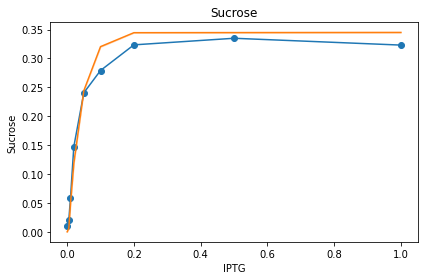

R2 = 0.9727615062368895,alpha: 4.11e-01,tau: 4.22e-02,c: 3.71e-01



Gaussian Process:  47%|████████████████████████████████████████████████████▎                                                           | 35/75 [38:33<44:07, 66.19s/it]

Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 66.3735
Function value obtained: 0.0233
Current minimum: 0.0233
Iteration No: 36 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 4.12e-01,tau2: 4.23e-02,c2: 3.71e-01
Recompiling NUFEB
Completed recompiling


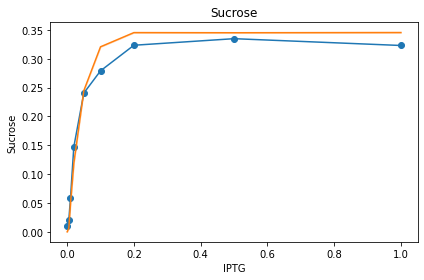

R2 = 0.9722484212354574,alpha: 4.12e-01,tau: 4.23e-02,c: 3.71e-01



Gaussian Process:  48%|█████████████████████████████████████████████████████▊                                                          | 36/75 [39:39<43:01, 66.19s/it]

Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 66.1763
Function value obtained: 0.0237
Current minimum: 0.0233
Iteration No: 37 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 4.30e-01,tau2: 4.07e-02,c2: 3.71e-01
Recompiling NUFEB
Completed recompiling


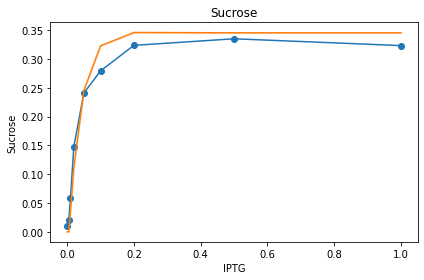

R2 = 0.9641324969227171,alpha: 4.30e-01,tau: 4.07e-02,c: 3.71e-01



Gaussian Process:  49%|███████████████████████████████████████████████████████▎                                                        | 37/75 [40:45<41:55, 66.19s/it]

Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 66.1937
Function value obtained: 0.0253
Current minimum: 0.0233
Iteration No: 38 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 5.09e-01,tau2: 3.58e-02,c2: 3.71e-01
Recompiling NUFEB
Completed recompiling


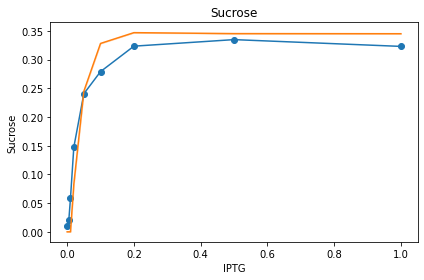

R2 = 0.9206388427836729,alpha: 5.09e-01,tau: 3.58e-02,c: 3.71e-01



Gaussian Process:  51%|████████████████████████████████████████████████████████▋                                                       | 38/75 [41:52<40:58, 66.44s/it]

Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 67.0317
Function value obtained: 0.0328
Current minimum: 0.0233
Iteration No: 39 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 4.70e-01,tau2: 3.83e-02,c2: 3.49e-01
Recompiling NUFEB
Completed recompiling


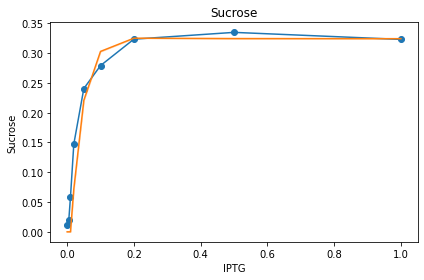

R2 = 0.9274559369932647,alpha: 4.70e-01,tau: 3.83e-02,c: 3.49e-01



Gaussian Process:  52%|██████████████████████████████████████████████████████████▏                                                     | 39/75 [42:58<39:48, 66.34s/it]

Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 66.1116
Function value obtained: 0.0277
Current minimum: 0.0233
Iteration No: 40 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 3.52e-01,tau2: 3.57e-02,c2: 3.49e-01
Recompiling NUFEB
Completed recompiling


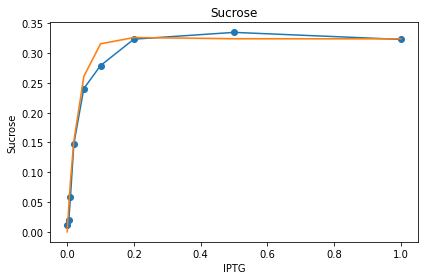

R2 = 0.9768189405324277,alpha: 3.52e-01,tau: 3.57e-02,c: 3.49e-01



Gaussian Process:  53%|███████████████████████████████████████████████████████████▋                                                    | 40/75 [44:05<38:41, 66.34s/it]

Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 66.3426
Function value obtained: 0.0183
Current minimum: 0.0183
Iteration No: 41 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 1.00e+00,tau2: 1.00e-03,c2: 1.00e-01
Recompiling NUFEB
Completed recompiling


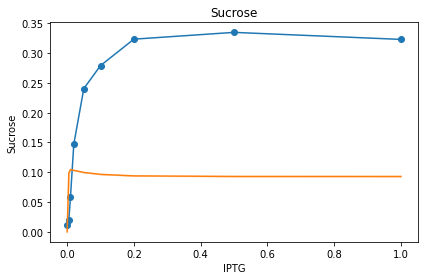

R2 = -0.5478286333689306,alpha: 1.00e+00,tau: 1.00e-03,c: 1.00e-01



Gaussian Process:  55%|█████████████████████████████████████████████████████████████▏                                                  | 41/75 [45:11<37:31, 66.23s/it]

Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 65.9530
Function value obtained: 0.1983
Current minimum: 0.0183
Iteration No: 42 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 3.46e-01,tau2: 1.00e-01,c2: 3.33e-01
Recompiling NUFEB
Completed recompiling


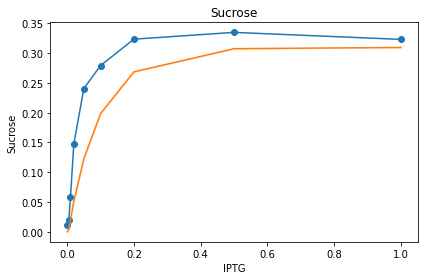

R2 = 0.7597562612636939,alpha: 3.46e-01,tau: 1.00e-01,c: 3.33e-01



Gaussian Process:  56%|██████████████████████████████████████████████████████████████▋                                                 | 42/75 [46:16<36:18, 66.03s/it]

Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 65.5733
Function value obtained: 0.0673
Current minimum: 0.0183
Iteration No: 43 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 3.30e-01,tau2: 4.24e-02,c2: 3.50e-01
Recompiling NUFEB
Completed recompiling


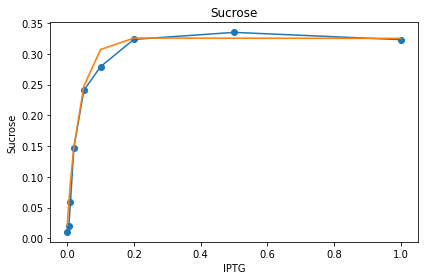

R2 = 0.9743385220000237,alpha: 3.30e-01,tau: 4.24e-02,c: 3.50e-01



Gaussian Process:  57%|████████████████████████████████████████████████████████████████▏                                               | 43/75 [47:22<35:13, 66.05s/it]

Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 66.1067
Function value obtained: 0.0145
Current minimum: 0.0145
Iteration No: 44 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 1.00e+00,tau2: 1.00e-01,c2: 3.17e-01
Recompiling NUFEB
Completed recompiling


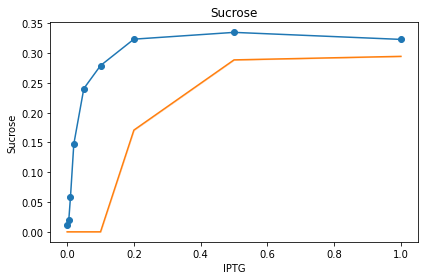

R2 = -0.2757848145117274,alpha: 1.00e+00,tau: 1.00e-01,c: 3.17e-01



Gaussian Process:  59%|█████████████████████████████████████████████████████████████████▋                                              | 44/75 [48:28<34:05, 65.97s/it]

Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 65.7766
Function value obtained: 0.1655
Current minimum: 0.0145
Iteration No: 45 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 2.89e-01,tau2: 5.31e-02,c2: 3.63e-01
Recompiling NUFEB
Completed recompiling


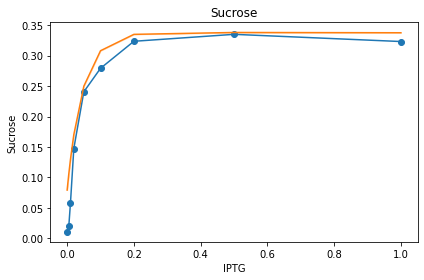

R2 = 0.8709740615273731,alpha: 2.89e-01,tau: 5.31e-02,c: 3.63e-01



Gaussian Process:  60%|███████████████████████████████████████████████████████████████████▏                                            | 45/75 [49:34<32:55, 65.87s/it]

Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 65.6328
Function value obtained: 0.0232
Current minimum: 0.0145
Iteration No: 46 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 1.13e-01,tau2: 5.19e-02,c2: 4.07e-01
Recompiling NUFEB
Completed recompiling


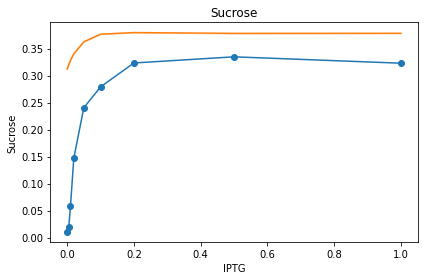

R2 = -1.206110275018693,alpha: 1.13e-01,tau: 5.19e-02,c: 4.07e-01



Gaussian Process:  61%|████████████████████████████████████████████████████████████████████▋                                           | 46/75 [50:40<31:50, 65.88s/it]

Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 65.9113
Function value obtained: 0.1111
Current minimum: 0.0145
Iteration No: 47 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 4.18e-01,tau2: 4.45e-02,c2: 3.07e-01
Recompiling NUFEB
Completed recompiling


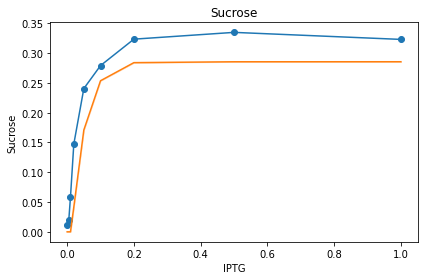

R2 = 0.823455414990734,alpha: 4.18e-01,tau: 4.45e-02,c: 3.07e-01



Gaussian Process:  63%|██████████████████████████████████████████████████████████████████████▏                                         | 47/75 [51:47<30:57, 66.35s/it]

Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 67.4571
Function value obtained: 0.0535
Current minimum: 0.0145
Iteration No: 48 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 3.26e-01,tau2: 4.65e-02,c2: 3.47e-01
Recompiling NUFEB
Completed recompiling


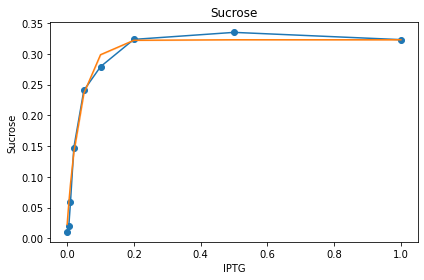

R2 = 0.9791031112778952,alpha: 3.26e-01,tau: 4.65e-02,c: 3.47e-01



Gaussian Process:  64%|███████████████████████████████████████████████████████████████████████▋                                        | 48/75 [52:54<29:52, 66.40s/it]

Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 66.5212
Function value obtained: 0.0120
Current minimum: 0.0120
Iteration No: 49 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 6.12e-01,tau2: 3.20e-02,c2: 4.01e-01
Recompiling NUFEB
Completed recompiling


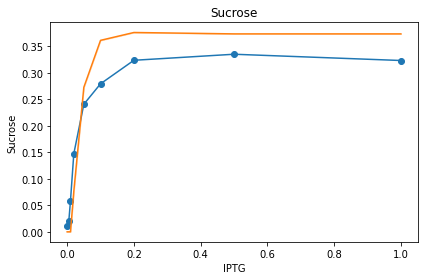

R2 = 0.8405969476614084,alpha: 6.12e-01,tau: 3.20e-02,c: 4.01e-01



Gaussian Process:  65%|█████████████████████████████████████████████████████████████████████████▏                                      | 49/75 [54:00<28:48, 66.48s/it]

Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 66.6798
Function value obtained: 0.0551
Current minimum: 0.0120
Iteration No: 50 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 3.92e-01,tau2: 4.12e-02,c2: 3.44e-01
Recompiling NUFEB
Completed recompiling


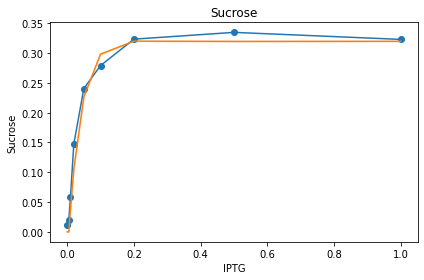

R2 = 0.9764199070870243,alpha: 3.92e-01,tau: 4.12e-02,c: 3.44e-01



Gaussian Process:  67%|██████████████████████████████████████████████████████████████████████████▋                                     | 50/75 [55:06<27:36, 66.26s/it]

Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 65.7259
Function value obtained: 0.0173
Current minimum: 0.0120
Iteration No: 51 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 9.93e-01,tau2: 1.15e-03,c2: 4.41e-01
Recompiling NUFEB
Completed recompiling


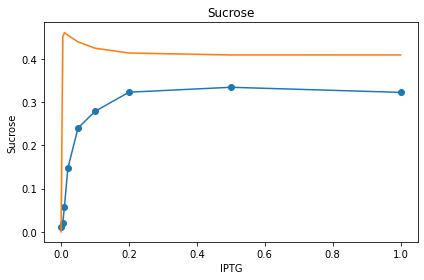

R2 = -2.5835674998221156,alpha: 9.93e-01,tau: 1.15e-03,c: 4.41e-01



Gaussian Process:  68%|████████████████████████████████████████████████████████████████████████████▏                                   | 51/75 [56:13<26:33, 66.41s/it]

Iteration No: 51 ended. Search finished for the next optimal point.
Time taken: 66.7664
Function value obtained: 0.1693
Current minimum: 0.0120
Iteration No: 52 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 3.41e-01,tau2: 4.95e-02,c2: 3.47e-01
Recompiling NUFEB
Completed recompiling


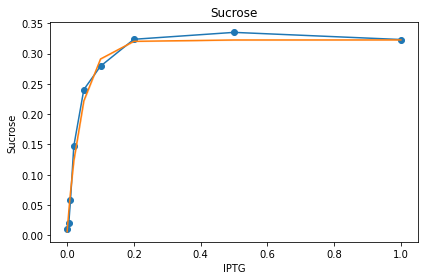

R2 = 0.9873059112805744,alpha: 3.41e-01,tau: 4.95e-02,c: 3.47e-01



Gaussian Process:  69%|█████████████████████████████████████████████████████████████████████████████▋                                  | 52/75 [57:20<25:31, 66.59s/it]

Iteration No: 52 ended. Search finished for the next optimal point.
Time taken: 67.0225
Function value obtained: 0.0129
Current minimum: 0.0120
Iteration No: 53 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 1.00e+00,tau2: 2.43e-02,c2: 3.15e-01
Recompiling NUFEB
Completed recompiling


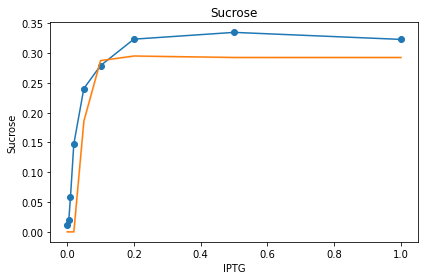

R2 = 0.7811476969227018,alpha: 1.00e+00,tau: 2.43e-02,c: 3.15e-01



Gaussian Process:  71%|███████████████████████████████████████████████████████████████████████████████▏                                | 53/75 [58:26<24:24, 66.56s/it]

Iteration No: 53 ended. Search finished for the next optimal point.
Time taken: 66.4855
Function value obtained: 0.0552
Current minimum: 0.0120
Iteration No: 54 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 3.14e-01,tau2: 4.76e-02,c2: 3.42e-01
Recompiling NUFEB
Completed recompiling


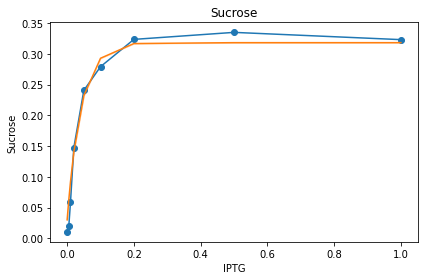

R2 = 0.972723583191145,alpha: 3.14e-01,tau: 4.76e-02,c: 3.42e-01



Gaussian Process:  72%|████████████████████████████████████████████████████████████████████████████████▋                               | 54/75 [59:33<23:19, 66.65s/it]

Iteration No: 54 ended. Search finished for the next optimal point.
Time taken: 66.8711
Function value obtained: 0.0132
Current minimum: 0.0120
Iteration No: 55 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 8.41e-01,tau2: 1.03e-02,c2: 2.50e-01
Recompiling NUFEB
Completed recompiling


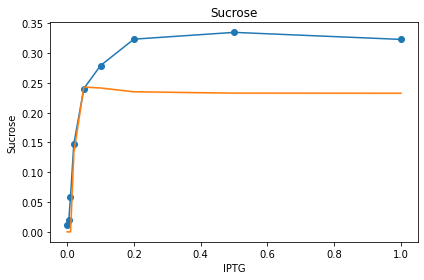

R2 = 0.7832328946627805,alpha: 8.41e-01,tau: 1.03e-02,c: 2.50e-01



Gaussian Process:  73%|████████████████████████████████████████████████████████████████████████████████▋                             | 55/75 [1:00:40<22:12, 66.62s/it]

Iteration No: 55 ended. Search finished for the next optimal point.
Time taken: 66.5540
Function value obtained: 0.0730
Current minimum: 0.0120
Iteration No: 56 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 1.00e+00,tau2: 4.98e-02,c2: 5.29e-01
Recompiling NUFEB
Completed recompiling


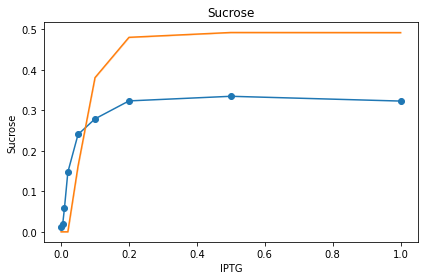

R2 = 0.1821839207190471,alpha: 1.00e+00,tau: 4.98e-02,c: 5.29e-01



Gaussian Process:  75%|██████████████████████████████████████████████████████████████████████████████████▏                           | 56/75 [1:01:48<21:12, 66.99s/it]

Iteration No: 56 ended. Search finished for the next optimal point.
Time taken: 67.8351
Function value obtained: 0.1385
Current minimum: 0.0120
Iteration No: 57 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 1.00e-01,tau2: 1.00e-03,c2: 2.38e-01
Recompiling NUFEB
Completed recompiling


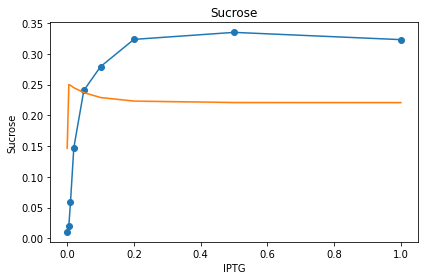

R2 = -0.04115854889796289,alpha: 1.00e-01,tau: 1.00e-03,c: 2.38e-01



Gaussian Process:  76%|███████████████████████████████████████████████████████████████████████████████████▌                          | 57/75 [1:02:54<20:04, 66.94s/it]

Iteration No: 57 ended. Search finished for the next optimal point.
Time taken: 66.8327
Function value obtained: 0.0973
Current minimum: 0.0120
Iteration No: 58 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 3.39e-01,tau2: 4.71e-02,c2: 3.49e-01
Recompiling NUFEB
Completed recompiling


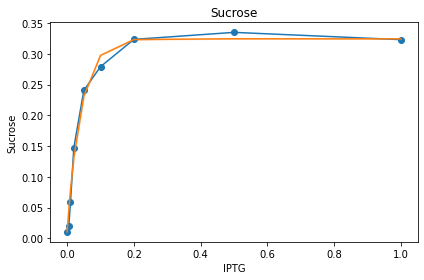

R2 = 0.9870614763362562,alpha: 3.39e-01,tau: 4.71e-02,c: 3.49e-01



Gaussian Process:  77%|█████████████████████████████████████████████████████████████████████████████████████                         | 58/75 [1:04:01<18:55, 66.77s/it]

Iteration No: 58 ended. Search finished for the next optimal point.
Time taken: 66.3694
Function value obtained: 0.0115
Current minimum: 0.0115
Iteration No: 59 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 3.41e-01,tau2: 4.72e-02,c2: 3.50e-01
Recompiling NUFEB
Completed recompiling


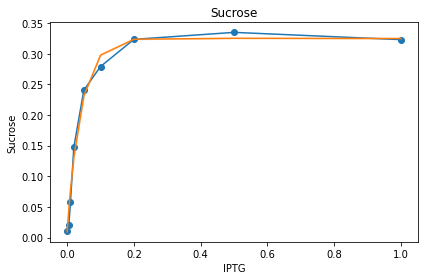

R2 = 0.9875726346650989,alpha: 3.41e-01,tau: 4.72e-02,c: 3.50e-01



Gaussian Process:  79%|██████████████████████████████████████████████████████████████████████████████████████▌                       | 59/75 [1:05:07<17:47, 66.73s/it]

Iteration No: 59 ended. Search finished for the next optimal point.
Time taken: 66.6603
Function value obtained: 0.0114
Current minimum: 0.0114
Iteration No: 60 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 3.42e-01,tau2: 4.72e-02,c2: 3.50e-01
Recompiling NUFEB
Completed recompiling


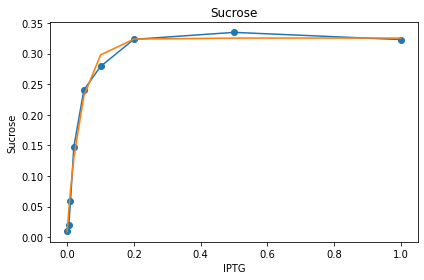

R2 = 0.9876802347421719,alpha: 3.42e-01,tau: 4.72e-02,c: 3.50e-01



Gaussian Process:  80%|████████████████████████████████████████████████████████████████████████████████████████                      | 60/75 [1:06:13<16:37, 66.49s/it]

Iteration No: 60 ended. Search finished for the next optimal point.
Time taken: 65.9313
Function value obtained: 0.0115
Current minimum: 0.0114
Iteration No: 61 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 3.42e-01,tau2: 4.72e-02,c2: 3.50e-01
Recompiling NUFEB
Completed recompiling


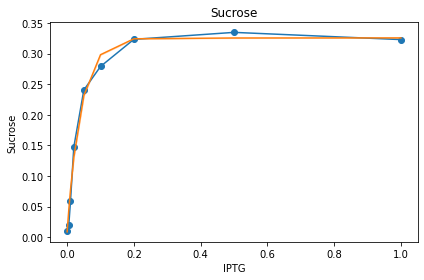

R2 = 0.9877234448189058,alpha: 3.42e-01,tau: 4.72e-02,c: 3.50e-01



Gaussian Process:  81%|█████████████████████████████████████████████████████████████████████████████████████████▍                    | 61/75 [1:07:20<15:31, 66.55s/it]

Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 66.6719
Function value obtained: 0.0115
Current minimum: 0.0114
Iteration No: 62 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 3.42e-01,tau2: 4.72e-02,c2: 3.50e-01
Recompiling NUFEB
Completed recompiling


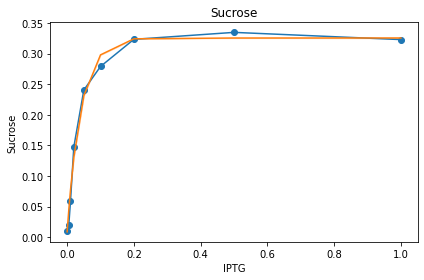

R2 = 0.987783684735406,alpha: 3.42e-01,tau: 4.72e-02,c: 3.50e-01



Gaussian Process:  83%|██████████████████████████████████████████████████████████████████████████████████████████▉                   | 62/75 [1:08:26<14:24, 66.52s/it]

Iteration No: 62 ended. Search finished for the next optimal point.
Time taken: 66.4823
Function value obtained: 0.0114
Current minimum: 0.0114
Iteration No: 63 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 1.00e+00,tau2: 1.00e-01,c2: 7.12e-01
Recompiling NUFEB
Completed recompiling


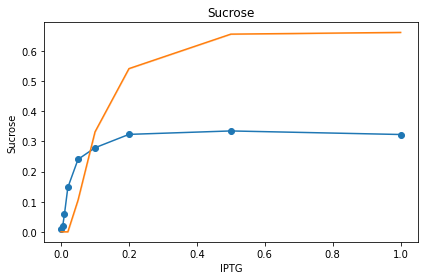

R2 = -1.125065099440337,alpha: 1.00e+00,tau: 1.00e-01,c: 7.12e-01



Gaussian Process:  84%|████████████████████████████████████████████████████████████████████████████████████████████▍                 | 63/75 [1:09:33<13:18, 66.55s/it]

Iteration No: 63 ended. Search finished for the next optimal point.
Time taken: 66.5930
Function value obtained: 0.2347
Current minimum: 0.0114
Iteration No: 64 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 3.42e-01,tau2: 4.72e-02,c2: 3.50e-01
Recompiling NUFEB
Completed recompiling


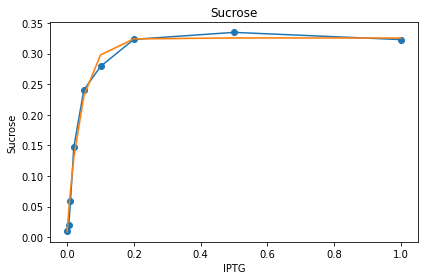

R2 = 0.9877986526247583,alpha: 3.42e-01,tau: 4.72e-02,c: 3.50e-01



Gaussian Process:  85%|█████████████████████████████████████████████████████████████████████████████████████████████▊                | 64/75 [1:10:40<12:13, 66.64s/it]

Iteration No: 64 ended. Search finished for the next optimal point.
Time taken: 66.9081
Function value obtained: 0.0114
Current minimum: 0.0114
Iteration No: 65 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 3.42e-01,tau2: 4.72e-02,c2: 3.50e-01
Recompiling NUFEB
Completed recompiling


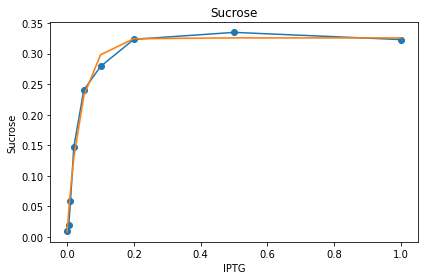

R2 = 0.987820955230414,alpha: 3.42e-01,tau: 4.72e-02,c: 3.50e-01



Gaussian Process:  87%|███████████████████████████████████████████████████████████████████████████████████████████████▎              | 65/75 [1:11:47<11:08, 66.87s/it]

Iteration No: 65 ended. Search finished for the next optimal point.
Time taken: 67.3641
Function value obtained: 0.0115
Current minimum: 0.0114
Iteration No: 66 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 3.42e-01,tau2: 4.72e-02,c2: 3.50e-01
Recompiling NUFEB
Completed recompiling


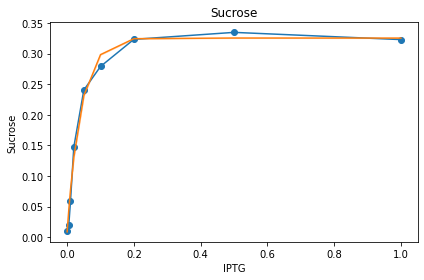

R2 = 0.9877199633932504,alpha: 3.42e-01,tau: 4.72e-02,c: 3.50e-01



Gaussian Process:  88%|████████████████████████████████████████████████████████████████████████████████████████████████▊             | 66/75 [1:12:54<10:02, 66.94s/it]

Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 67.0880
Function value obtained: 0.0115
Current minimum: 0.0114
Iteration No: 67 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 3.42e-01,tau2: 4.72e-02,c2: 3.50e-01
Recompiling NUFEB
Completed recompiling


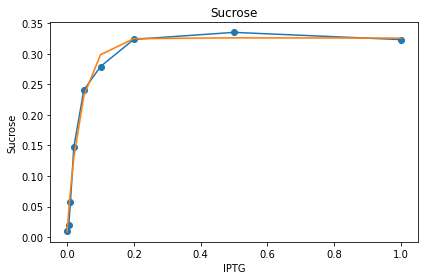

R2 = 0.987688208129776,alpha: 3.42e-01,tau: 4.72e-02,c: 3.50e-01



Gaussian Process:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████▎           | 67/75 [1:14:01<08:54, 66.77s/it]

Iteration No: 67 ended. Search finished for the next optimal point.
Time taken: 66.3755
Function value obtained: 0.0115
Current minimum: 0.0114
Iteration No: 68 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 3.40e-01,tau2: 4.71e-02,c2: 3.51e-01
Recompiling NUFEB
Completed recompiling


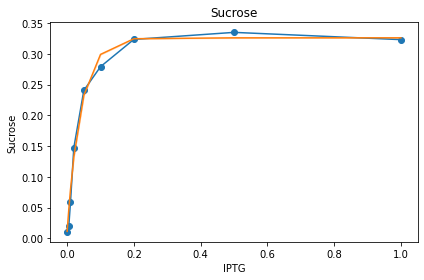

R2 = 0.9866432635474719,alpha: 3.40e-01,tau: 4.71e-02,c: 3.51e-01



Gaussian Process:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████▋          | 68/75 [1:15:08<07:47, 66.75s/it]

Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 66.7280
Function value obtained: 0.0115
Current minimum: 0.0114
Iteration No: 69 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 3.45e-01,tau2: 4.71e-02,c2: 3.50e-01
Recompiling NUFEB
Completed recompiling


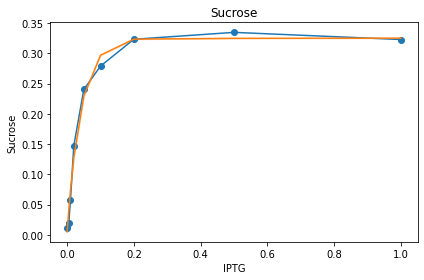

R2 = 0.9887045715588902,alpha: 3.45e-01,tau: 4.71e-02,c: 3.50e-01



Gaussian Process:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 69/75 [1:16:14<06:39, 66.58s/it]

Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 66.1630
Function value obtained: 0.0116
Current minimum: 0.0114
Iteration No: 70 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 3.37e-01,tau2: 4.71e-02,c2: 3.51e-01
Recompiling NUFEB
Completed recompiling


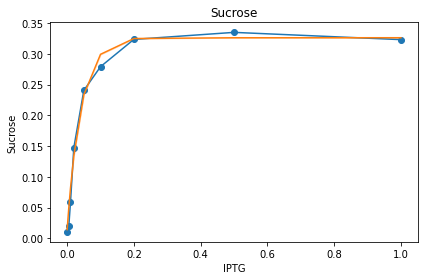

R2 = 0.9852721686796119,alpha: 3.37e-01,tau: 4.71e-02,c: 3.51e-01



Gaussian Process:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 70/75 [1:17:21<05:33, 66.78s/it]

Iteration No: 70 ended. Search finished for the next optimal point.
Time taken: 67.2471
Function value obtained: 0.0115
Current minimum: 0.0114
Iteration No: 71 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 3.45e-01,tau2: 4.71e-02,c2: 3.49e-01
Recompiling NUFEB
Completed recompiling


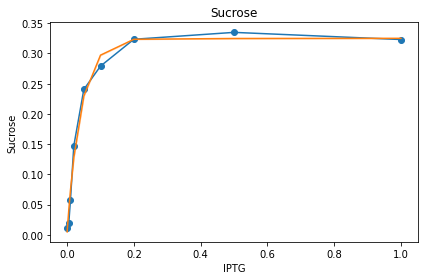

R2 = 0.9885621700046546,alpha: 3.45e-01,tau: 4.71e-02,c: 3.49e-01



Gaussian Process:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 71/75 [1:18:27<04:26, 66.63s/it]

Iteration No: 71 ended. Search finished for the next optimal point.
Time taken: 66.2837
Function value obtained: 0.0117
Current minimum: 0.0114
Iteration No: 72 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 1.00e-01,tau2: 4.34e-02,c2: 1.00e-01
Recompiling NUFEB
Completed recompiling


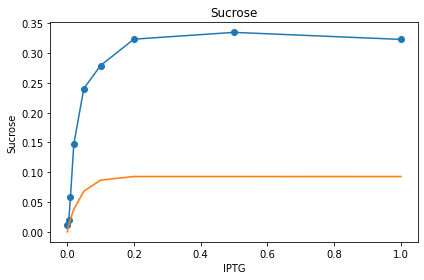

R2 = -0.6634069025933329,alpha: 1.00e-01,tau: 4.34e-02,c: 1.00e-01



Gaussian Process:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 72/75 [1:19:34<03:19, 66.61s/it]

Iteration No: 72 ended. Search finished for the next optimal point.
Time taken: 66.5841
Function value obtained: 0.2052
Current minimum: 0.0114
Iteration No: 73 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 3.36e-01,tau2: 4.72e-02,c2: 3.51e-01
Recompiling NUFEB
Completed recompiling


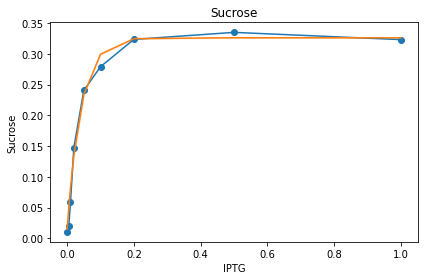

R2 = 0.9847641628783173,alpha: 3.36e-01,tau: 4.72e-02,c: 3.51e-01



Gaussian Process:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████   | 73/75 [1:20:41<02:13, 66.72s/it]

Iteration No: 73 ended. Search finished for the next optimal point.
Time taken: 66.9581
Function value obtained: 0.0115
Current minimum: 0.0114
Iteration No: 74 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 3.37e-01,tau2: 4.72e-02,c2: 3.51e-01
Recompiling NUFEB
Completed recompiling


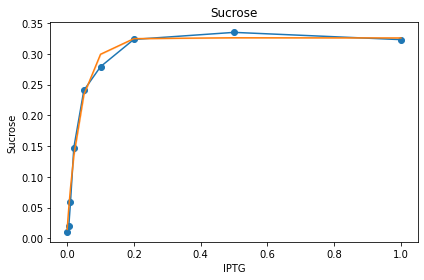

R2 = 0.9850684754327511,alpha: 3.37e-01,tau: 4.72e-02,c: 3.51e-01



Gaussian Process:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 74/75 [1:21:48<01:06, 66.86s/it]

Iteration No: 74 ended. Search finished for the next optimal point.
Time taken: 67.1898
Function value obtained: 0.0115
Current minimum: 0.0114
Iteration No: 75 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 3.44e-01,tau2: 4.70e-02,c2: 3.49e-01
Recompiling NUFEB
Completed recompiling


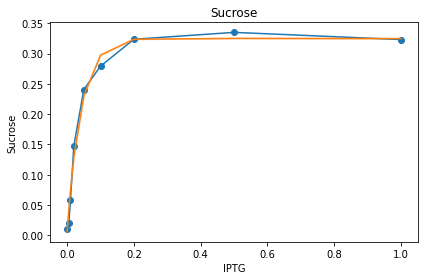

R2 = 0.9885363900059766,alpha: 3.44e-01,tau: 4.70e-02,c: 3.49e-01



Gaussian Process: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [1:22:55<00:00, 66.88s/it]

Iteration No: 75 ended. Search finished for the next optimal point.
Time taken: 66.9262
Function value obtained: 0.0115
Current minimum: 0.0114
Iteration No: 76 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 3.37e-01,tau2: 4.72e-02,c2: 3.51e-01
Recompiling NUFEB
Completed recompiling


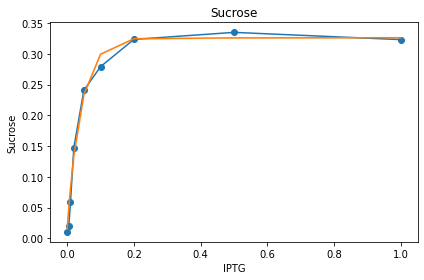

R2 = 0.9848273029438048,alpha: 3.37e-01,tau: 4.72e-02,c: 3.51e-01



Gaussian Process: 76it [1:24:01, 66.77s/it]                                                                                                                            

Iteration No: 76 ended. Search finished for the next optimal point.
Time taken: 66.5168
Function value obtained: 0.0116
Current minimum: 0.0114
Iteration No: 77 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 3.44e-01,tau2: 4.70e-02,c2: 3.49e-01
Recompiling NUFEB
Completed recompiling


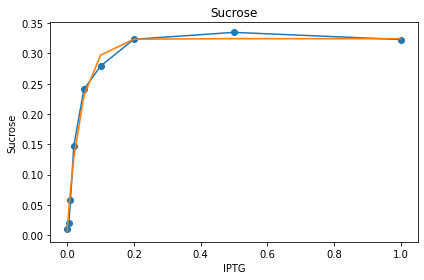

R2 = 0.988528201408379,alpha: 3.44e-01,tau: 4.70e-02,c: 3.49e-01



Gaussian Process: 77it [1:25:08, 66.75s/it]

Iteration No: 77 ended. Search finished for the next optimal point.
Time taken: 66.7031
Function value obtained: 0.0116
Current minimum: 0.0114
Iteration No: 78 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 3.36e-01,tau2: 4.72e-02,c2: 3.51e-01
Recompiling NUFEB
Completed recompiling


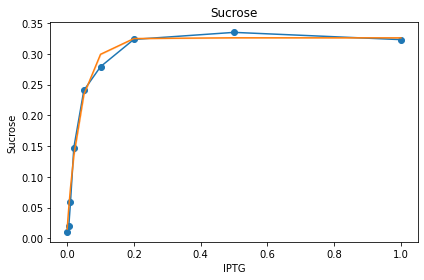

R2 = 0.984771898187558,alpha: 3.36e-01,tau: 4.72e-02,c: 3.51e-01



Gaussian Process: 78it [1:26:15, 66.78s/it]

Iteration No: 78 ended. Search finished for the next optimal point.
Time taken: 66.8493
Function value obtained: 0.0115
Current minimum: 0.0114
Iteration No: 79 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 3.45e-01,tau2: 4.75e-02,c2: 3.50e-01
Recompiling NUFEB
Completed recompiling


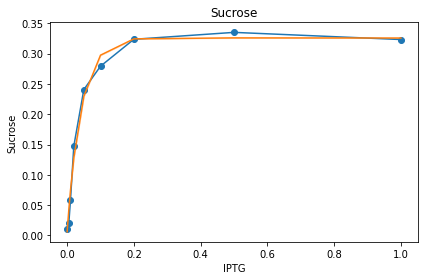

R2 = 0.9884879747105614,alpha: 3.45e-01,tau: 4.75e-02,c: 3.50e-01



Gaussian Process: 79it [1:27:22, 66.93s/it]

Iteration No: 79 ended. Search finished for the next optimal point.
Time taken: 67.2825
Function value obtained: 0.0116
Current minimum: 0.0114
Iteration No: 80 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 3.36e-01,tau2: 4.72e-02,c2: 3.51e-01
Recompiling NUFEB
Completed recompiling


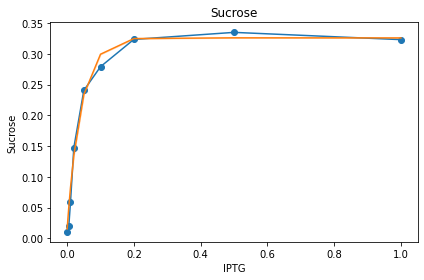

R2 = 0.9846024468947524,alpha: 3.36e-01,tau: 4.72e-02,c: 3.51e-01



Gaussian Process: 80it [1:28:29, 66.98s/it]

Iteration No: 80 ended. Search finished for the next optimal point.
Time taken: 67.0947
Function value obtained: 0.0116
Current minimum: 0.0114
Iteration No: 81 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 3.42e-01,tau2: 4.69e-02,c2: 3.49e-01
Recompiling NUFEB
Completed recompiling


--------------------------------------------------------------------------
mpirun has exited due to process rank 0 with PID 0 on
node PRL-DUCAT-WS6 exiting improperly. There are three reasons this could occur:

1. this process did not call "init" before exiting, but others in
the job did. This can cause a job to hang indefinitely while it waits
for all processes to call "init". By rule, if one process calls "init",
then ALL processes must call "init" prior to termination.

2. this process called "init", but exited without calling "finalize".
By rule, all processes that call "init" MUST call "finalize" prior to
exiting or it will be considered an "abnormal termination"

3. this process called "MPI_Abort" or "orte_abort" and the mca parameter
orte_create_session_dirs is set to false. In this case, the run-time cannot
detect that the abort call was an abnormal termination. Hence, the only
error message you will receive is this one.

This may have caused other processes in the application 

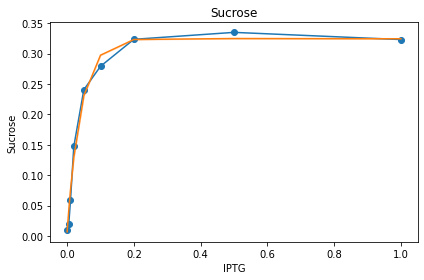

R2 = 0.9883066098163036,alpha: 3.42e-01,tau: 4.69e-02,c: 3.49e-01



Gaussian Process: 81it [1:29:43, 69.06s/it]

Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 73.9224
Function value obtained: 0.0115
Current minimum: 0.0114
Iteration No: 82 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 3.42e-01,tau2: 4.68e-02,c2: 3.49e-01
Recompiling NUFEB
Completed recompiling


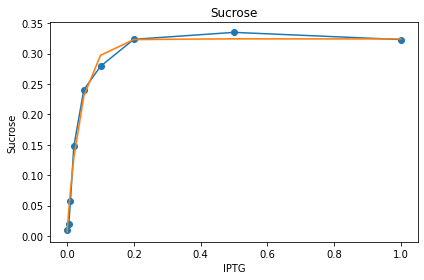

R2 = 0.9882278865243934,alpha: 3.42e-01,tau: 4.68e-02,c: 3.49e-01



Gaussian Process: 82it [1:30:50, 68.52s/it]

Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 67.2864
Function value obtained: 0.0115
Current minimum: 0.0114
Iteration No: 83 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 3.36e-01,tau2: 4.72e-02,c2: 3.51e-01
Recompiling NUFEB
Completed recompiling


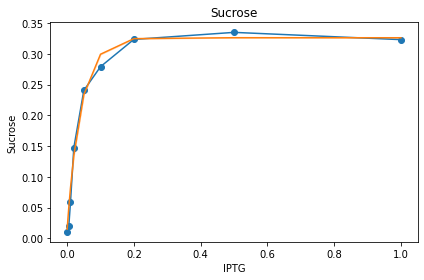

R2 = 0.9848285900162412,alpha: 3.36e-01,tau: 4.72e-02,c: 3.51e-01



Gaussian Process: 83it [1:31:58, 68.33s/it]

Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 67.8848
Function value obtained: 0.0115
Current minimum: 0.0114
Iteration No: 84 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 3.43e-01,tau2: 4.69e-02,c2: 3.49e-01
Recompiling NUFEB
Completed recompiling


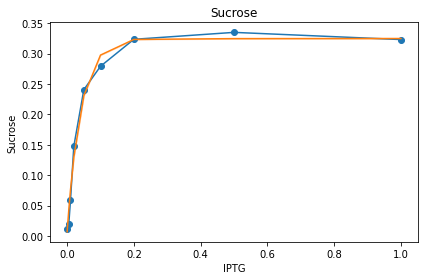

R2 = 0.9882989723349804,alpha: 3.43e-01,tau: 4.69e-02,c: 3.49e-01



Gaussian Process: 84it [1:33:06, 68.05s/it]

Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 67.3818
Function value obtained: 0.0115
Current minimum: 0.0114
Iteration No: 85 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 3.45e-01,tau2: 4.76e-02,c2: 3.51e-01
Recompiling NUFEB
Completed recompiling


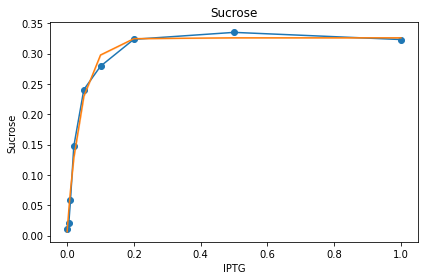

R2 = 0.9883600150032191,alpha: 3.45e-01,tau: 4.76e-02,c: 3.51e-01



Gaussian Process: 85it [1:34:13, 67.66s/it]

Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 66.7573
Function value obtained: 0.0116
Current minimum: 0.0114
Iteration No: 86 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 3.36e-01,tau2: 4.71e-02,c2: 3.50e-01
Recompiling NUFEB
Completed recompiling


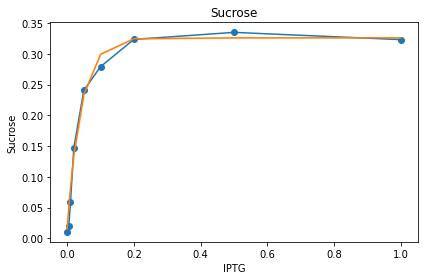

R2 = 0.9846805251441774,alpha: 3.36e-01,tau: 4.71e-02,c: 3.50e-01



Gaussian Process: 86it [1:35:20, 67.59s/it]

Iteration No: 86 ended. Search finished for the next optimal point.
Time taken: 67.4515
Function value obtained: 0.0115
Current minimum: 0.0114
Iteration No: 87 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 3.41e-01,tau2: 4.68e-02,c2: 3.49e-01
Recompiling NUFEB
Completed recompiling


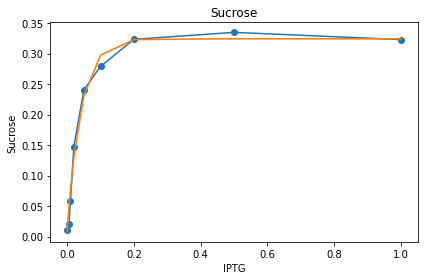

R2 = 0.9879647030290283,alpha: 3.41e-01,tau: 4.68e-02,c: 3.49e-01



Gaussian Process: 87it [1:36:28, 67.61s/it]

Iteration No: 87 ended. Search finished for the next optimal point.
Time taken: 67.6484
Function value obtained: 0.0115
Current minimum: 0.0114
Iteration No: 88 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 3.36e-01,tau2: 4.71e-02,c2: 3.50e-01
Recompiling NUFEB
Completed recompiling


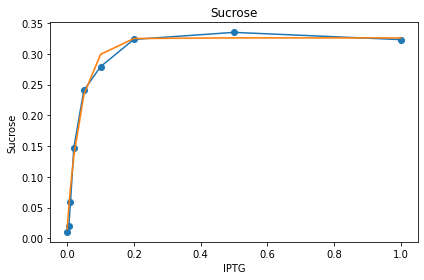

R2 = 0.9847145430254886,alpha: 3.36e-01,tau: 4.71e-02,c: 3.50e-01



Gaussian Process: 88it [1:37:35, 67.40s/it]

Iteration No: 88 ended. Search finished for the next optimal point.
Time taken: 66.9048
Function value obtained: 0.0115
Current minimum: 0.0114
Iteration No: 89 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 3.42e-01,tau2: 4.68e-02,c2: 3.49e-01
Recompiling NUFEB
Completed recompiling


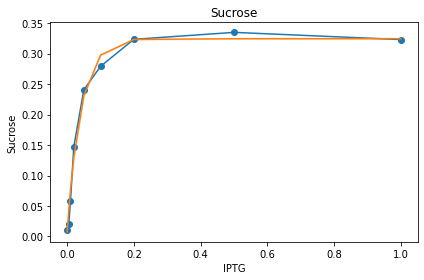

R2 = 0.988043886408487,alpha: 3.42e-01,tau: 4.68e-02,c: 3.49e-01



Gaussian Process: 89it [1:38:42, 67.57s/it]

Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 67.9949
Function value obtained: 0.0115
Current minimum: 0.0114
Iteration No: 90 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 3.42e-01,tau2: 4.68e-02,c2: 3.49e-01
Recompiling NUFEB
Completed recompiling


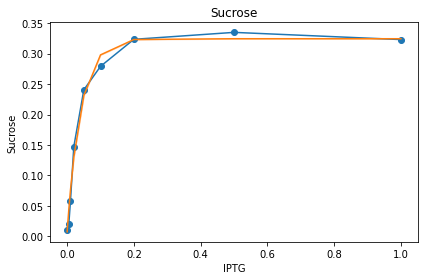

R2 = 0.9880282399187913,alpha: 3.42e-01,tau: 4.68e-02,c: 3.49e-01



Gaussian Process: 90it [1:39:49, 67.33s/it]

Iteration No: 90 ended. Search finished for the next optimal point.
Time taken: 66.7547
Function value obtained: 0.0116
Current minimum: 0.0114
Iteration No: 91 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 3.44e-01,tau2: 4.75e-02,c2: 3.51e-01
Recompiling NUFEB
Completed recompiling


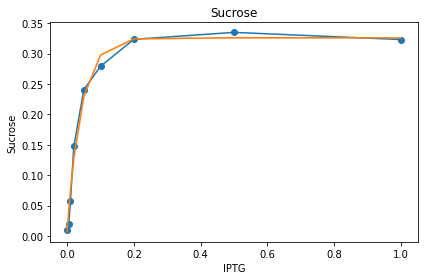

R2 = 0.9882480276031839,alpha: 3.44e-01,tau: 4.75e-02,c: 3.51e-01



Gaussian Process: 91it [1:40:56, 67.28s/it]

Iteration No: 91 ended. Search finished for the next optimal point.
Time taken: 67.1798
Function value obtained: 0.0116
Current minimum: 0.0114
Iteration No: 92 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 3.36e-01,tau2: 4.71e-02,c2: 3.50e-01
Recompiling NUFEB
Completed recompiling


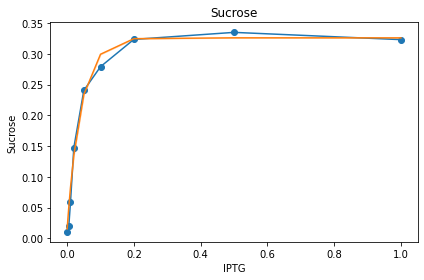

R2 = 0.9846023782826883,alpha: 3.36e-01,tau: 4.71e-02,c: 3.50e-01



Gaussian Process: 92it [1:42:04, 67.37s/it]

Iteration No: 92 ended. Search finished for the next optimal point.
Time taken: 67.5890
Function value obtained: 0.0115
Current minimum: 0.0114
Iteration No: 93 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 3.36e-01,tau2: 4.71e-02,c2: 3.50e-01
Recompiling NUFEB
Completed recompiling


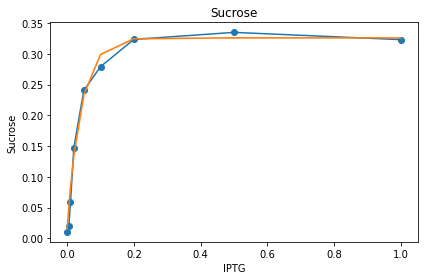

R2 = 0.9847012449416578,alpha: 3.36e-01,tau: 4.71e-02,c: 3.50e-01



Gaussian Process: 93it [1:43:12, 67.41s/it]

Iteration No: 93 ended. Search finished for the next optimal point.
Time taken: 67.5126
Function value obtained: 0.0115
Current minimum: 0.0114
Iteration No: 94 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 3.41e-01,tau2: 4.68e-02,c2: 3.49e-01
Recompiling NUFEB
Completed recompiling


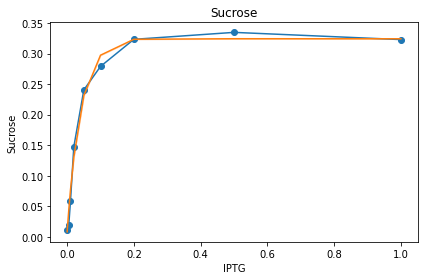

R2 = 0.9879856164977612,alpha: 3.41e-01,tau: 4.68e-02,c: 3.49e-01



Gaussian Process: 94it [1:44:18, 67.27s/it]

Iteration No: 94 ended. Search finished for the next optimal point.
Time taken: 66.9407
Function value obtained: 0.0114
Current minimum: 0.0114
Iteration No: 95 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 3.36e-01,tau2: 4.71e-02,c2: 3.50e-01
Recompiling NUFEB
Completed recompiling


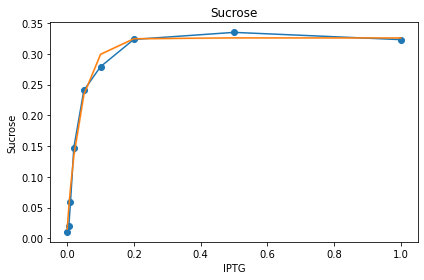

R2 = 0.9847909623375289,alpha: 3.36e-01,tau: 4.71e-02,c: 3.50e-01



Gaussian Process: 95it [1:45:25, 67.14s/it]

Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 66.8478
Function value obtained: 0.0115
Current minimum: 0.0114
Iteration No: 96 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 3.42e-01,tau2: 4.68e-02,c2: 3.49e-01
Recompiling NUFEB
Completed recompiling


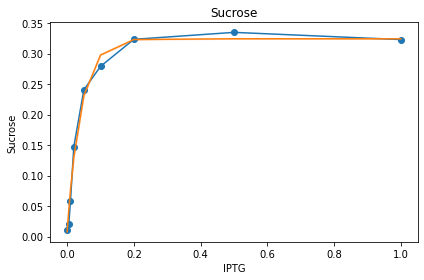

R2 = 0.9879708254767954,alpha: 3.42e-01,tau: 4.68e-02,c: 3.49e-01



Gaussian Process: 96it [1:46:32, 67.13s/it]

Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 67.1048
Function value obtained: 0.0115
Current minimum: 0.0114
Iteration No: 97 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 3.41e-01,tau2: 4.68e-02,c2: 3.49e-01
Recompiling NUFEB
Completed recompiling


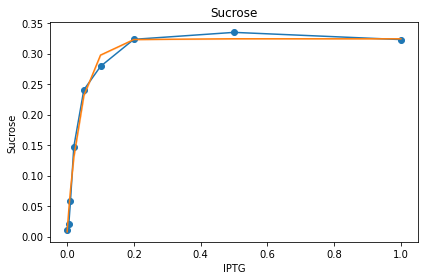

R2 = 0.9879691622013893,alpha: 3.41e-01,tau: 4.68e-02,c: 3.49e-01



Gaussian Process: 97it [1:47:39, 67.09s/it]

Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 67.0035
Function value obtained: 0.0115
Current minimum: 0.0114
Iteration No: 98 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 3.36e-01,tau2: 4.71e-02,c2: 3.50e-01
Recompiling NUFEB
Completed recompiling


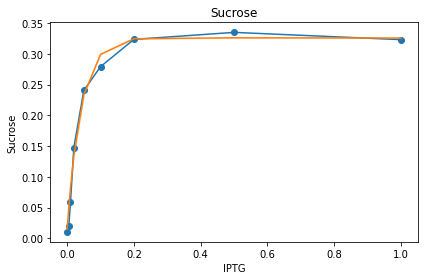

R2 = 0.9849313654049483,alpha: 3.36e-01,tau: 4.71e-02,c: 3.50e-01



Gaussian Process: 98it [1:48:47, 67.20s/it]

Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 67.4512
Function value obtained: 0.0115
Current minimum: 0.0114
Iteration No: 99 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 3.44e-01,tau2: 4.75e-02,c2: 3.50e-01
Recompiling NUFEB
Completed recompiling


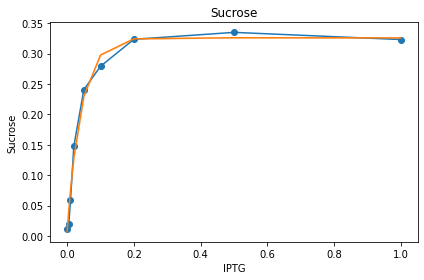

R2 = 0.9882976823198291,alpha: 3.44e-01,tau: 4.75e-02,c: 3.50e-01



Gaussian Process: 99it [1:49:54, 67.09s/it]

Iteration No: 99 ended. Search finished for the next optimal point.
Time taken: 66.8367
Function value obtained: 0.0115
Current minimum: 0.0114
Iteration No: 100 started. Searching for the next optimal point.
alpha: 1.45e-01,tau: 7.73e-02,c: 8.54e-01,alpha2: 3.41e-01,tau2: 4.68e-02,c2: 3.49e-01
Recompiling NUFEB
Completed recompiling


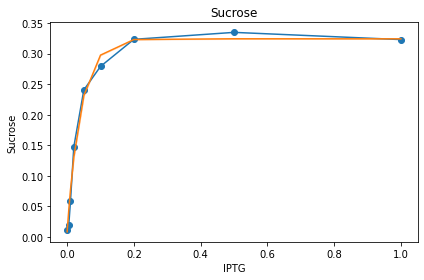

R2 = 0.987870949066405,alpha: 3.41e-01,tau: 4.68e-02,c: 3.49e-01



Gaussian Process: 100it [1:51:02, 67.32s/it]

Iteration No: 100 ended. Search finished for the next optimal point.
Time taken: 67.8776
Function value obtained: 0.0115
Current minimum: 0.0114


In [106]:
alpha2_min = float('1e-1')
alpha2_max = float('1e0')
tau2_min = float('1e-3')
tau2_max = float('1e-1')
c2_min = float('1e-1')
c2_max = float('1e0')

suc_bounds = [(alpha2_min,alpha2_max),(tau2_min,tau2_max),(c2_min,c2_max)]#,
checkpoint_saver_suc = CheckpointSaver('se-suc.pkl', compress=9)


suc_res = gp_minimize(suc_objective, suc_bounds,
        n_calls=100,n_initial_points=20,callback=[tqdm_skopt(total=n_calls, desc="Gaussian Process"),checkpoint_saver_suc],verbose=True,random_state=777)

In [107]:
suc_res = load('se-suc.pkl')

Gaussian Process: 100it [1:51:02, 66.62s/it]


<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

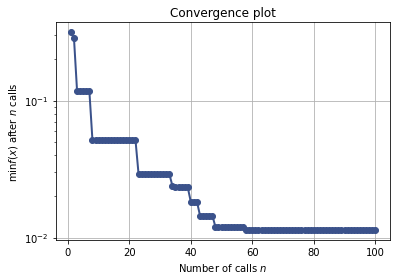

In [108]:
plot_convergence(suc_res,yscale='log')

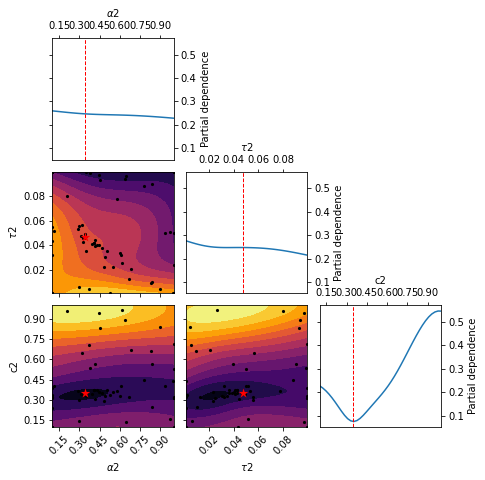

In [109]:
axes = plot_objective(suc_res,dimensions=[r'$\alpha2$',r'$\tau2$','c2'],cmap='inferno')

In [110]:
suc_res.x

[0.3407800184487689, 0.04716083805871045, 0.3497009267626362]

In [111]:
od_res.x[0],od_res.x[1],od_res.x[2],suc_res.x[0],suc_res.x[1],suc_res.x[2]

(0.1451479831263119,
 0.07730685545947749,
 0.8544223546219633,
 0.3407800184487689,
 0.04716083805871045,
 0.3497009267626362)

In [112]:
recompile(od_res.x[0],od_res.x[1],od_res.x[2],suc_res.x[0],suc_res.x[1],suc_res.x[2])

Recompiling NUFEB
Completed recompiling


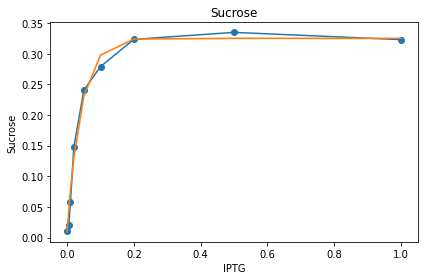

In [113]:
#recompile(a,tau,c,a2,tau2,c2)
#Clean old simulations
mu=mu_res.x[0]
os.chdir('/home/jsakkos/NUFEB')
os.system('nufeb-clean')
#Seed new simulations
for iptg in test_data.IPTG:
    text = f'nufeb-seed --n 3 --od 0.3,0 --d 1e-4,1e-4,1e-4 --grid 20 --t 8700 --mucya {mu} --iptg {iptg} --niter 1000'
    os.system(text)
#Run new simulations
os.system('/home/jsakkos/par.sh')
BASE_DIR = Path(f'runs/')
folders = [path for path in BASE_DIR.iterdir() if path.is_dir()]

#Extract output
n=0
while True:
    tmp=Parallel(n_jobs=-1)(delayed(collect_data)(folder) for folder in folders)
    data = pd.concat(tmp,ignore_index=True)
    df = data.loc[(data.Hours == data.Hours.iloc[-1])]
    df = df.sort_values(by='IPTG')
    df = df.reset_index()
    temp = df.groupby('IPTG').mean().reset_index()
    if len(test_data.Sucrose)==len(temp.Sucrose):
        break
    elif n >=3:
        print('Tried to import 3 times')
        break
    else:
        n+=1
#save in progress plot
f, ax = plt.subplots()
ax.set_title('Sucrose')
ax.plot(test_data.IPTG,test_data.Sucrose,marker='o')
sns.lineplot(x='IPTG',y='Sucrose',ax=ax,data=df)
f.tight_layout()
plt.show()



In [115]:
#Compare output with experimental data via RMSE
SUCerr = mean_squared_error(test_data.Sucrose,temp.Sucrose,sample_weight=test_data.Sucrose,squared=False)
r2_value = r2_score(test_data.Sucrose,temp.Sucrose)
print(f'R2 = {r2_value},alpha: {suc_res.x[0]:.2e},tau: {suc_res.x[1]:.2e},c: {suc_res.x[2]:.2e}')

R2 = 0.9874932510078347,alpha: 3.41e-01,tau: 4.72e-02,c: 3.50e-01


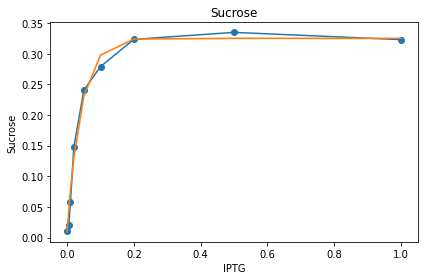

In [114]:
f, ax = plt.subplots()
ax.set_title('Sucrose')
ax.plot(test_data.IPTG,test_data.Sucrose,marker='o')
sns.lineplot(x='IPTG',y='Sucrose',ax=ax,data=df)
f.tight_layout()
plt.show()

alpha: 1.36e-01,tau: 7.12e-02,c: 7.93e-01,alpha2: 3.25e-01,tau2: 4.68e-02,c2: 3.38e-01


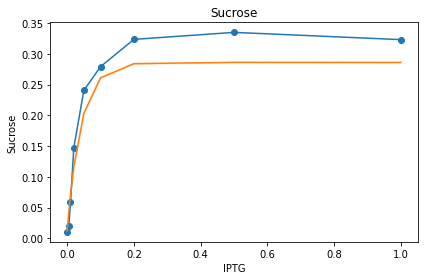

R2 = 0.9411628286169582,alpha: 3.25e-01,tau: 4.68e-02,c: 3.38e-01


0.03656326077238922

In [69]:
suc_objective([suc_res.x[0],suc_res.x[1],suc_res.x[2]])

In [66]:
def suc_objective2(x):
    a2 = x[0]
    tau2 = x[1]
    c2 = x[2]
    print(f'alpha: {a:.2e},tau: {tau:.2e},c: {c:.2e},alpha2: {a2:.2e},tau2: {tau2:.2e},c2: {c2:.2e}')
    #if all(suc_func(a2,tau2,c2,iptg) <=0 for iptg in test_data.IPTG):
    #    return 100
    #elif all(suc_func(a2,tau2,c2,iptg) >1 for iptg in test_data.IPTG):
    #    return 100
    recompile(a,tau,c,a2,tau2,c2)
    #Clean old simulations
    os.chdir('/home/jsakkos/NUFEB')
    os.system('nufeb-clean')
    #Seed new simulations
    for iptg in test_data.IPTG:
        text = f'nufeb-seed --n 1 --od 0.3,0 --d 1e-4,1e-4,1e-4 --grid 20 --t 8700 --mucya {mu} --iptg {iptg} --niter 1000'
        os.system(text)
    #Run new simulations
    os.system('/home/jsakkos/par.sh')
    BASE_DIR = Path(f'runs/')
    folders = [path for path in BASE_DIR.iterdir() if path.is_dir()]

    #Extract output
    n=0
    while True:
        tmp=Parallel(n_jobs=-1)(delayed(collect_data)(folder) for folder in folders)
        data = pd.concat(tmp,ignore_index=True)
        df = data.loc[(data.Hours == data.Hours.iloc[-1])]
        df = df.sort_values(by='IPTG')
        df = df.reset_index()
        temp = df.groupby('IPTG').mean().reset_index()
        if len(test_data.Sucrose)==len(temp.Sucrose):
            break
        elif n >=3:
            print('Tried to import 3 times')
            break
        else:
            n+=1
    #save in progress plot
    f, ax = plt.subplots(ncols=2)
    ax[0].set_title('Sucrose')
    ax[0].plot(test_data.IPTG,test_data.Sucrose,marker='o')
    sns.lineplot(x='IPTG',y='Sucrose',ax=ax[0],data=df)
    ax[1].set_title('OD750')
    ax[1].plot(test_data.IPTG,test_data.OD750,marker='o')
    sns.lineplot(x='IPTG',y='OD750',ax=ax[1],data=df)
    f.tight_layout()
    plt.show()

    #Compare output with experimental data via RMSE
    SUCerr = mean_squared_error(test_data.Sucrose,temp.Sucrose,sample_weight=test_data.Sucrose,squared=False)
    r2_value = r2_score(test_data.Sucrose,temp.Sucrose)
    print(f'R2 = {r2_value},alpha: {a2:.2e},tau: {tau2:.2e},c: {c2:.2e}')
    return SUCerr

alpha: 1.36e-01,tau: 7.12e-02,c: 7.93e-01,alpha2: 3.25e-01,tau2: 4.68e-02,c2: 3.38e-01


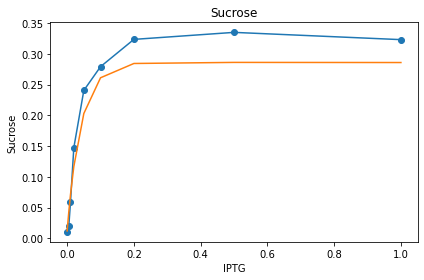

R2 = 0.9410378863467801,alpha: 3.25e-01,tau: 4.68e-02,c: 3.38e-01


0.03660323214997077

In [67]:
suc_objective2([suc_res.x[0],suc_res.x[1],suc_res.x[2]])